# The Enron dataset - understanding employee e-mails through network science and NLP

# Motivation

## What is your dataset?


In this project assignment, we have choosen to investigate the Enron-email dataset (link can be found on website), which conists of more than 500.000 e-mails between employees in Enron. 
In its heydays, Enron was known as a respectable, ingenious and innovative company, set to alter the financial system underpinning the energy sector. All the fancy words aside, as it turned out, Enron was nothing more than a "good ol'" scam. Due to the severity of its misdemeanors, investigators thought it necessary to access the employees e-mails to ensure a swift and adequate litigation process. These e-mails were subsequently sold to the University of Massachusetts, Amhurst, for research purposes, and later made publicly available.

## Why did you choose this dataset?

The Enron e-mail dataset offers researchers in a plethora of scientific disciplines, a unique glimpse into the inner workings of a company about to go bust! 
The main reasons for us choosing this dataset lies in the very private and informative nature of e-mail activity. As such the dataset is very unique, as e-mail activity is a rare source of data, due to privacy considerations. Further, due to the fact that e-mails has a sender and a receiver, the parallel to graphs is straightforward, inviting network science to be applied. Combining this with the content of the emails, which can readily be analyzed through NLP-measures, one has a powerfull, wide and elaborative window into the thoughts, feelings and actions of a bulk of individuals. 

## What was your goal for the end user's experience?

Our goal is overall to offer readers an informative and easy interpretable window into the inner workings of Enron in its final days. Our hope is that NLP and network science will give the reader a nuanced understanding of the company, which could not have been reached with non-datascience analyses. As such, we also wish to demonstrate the applicability of these measure and relate them to conventional analyses, describing strenghts and weaknesses. 
Hereby, the reader will both receive an elaborate introduction to Enron, while at the same time being invited to reflect upon the qualities and limitations of the methods applied

Whats more, in order to allow for the network science and NLP-measure to relate and corroborate each other, we have chooesen to draw on the work by Joorabchi, Jim and Shaw (2010), who analysed the e-mail dataset in terms of the individuals occupation categories (See website for details and presentation of litterature).
For the network science part, we will therefore see if the individuals flagged as central in various metrics (degree, centrality etc) also appear to have influential, high-ranking titels. For the NLP-part, the individuals will be subdivided into occupation categories (Top, middle and lower) in order to allow for more fruitful and elaborate analyses. 
We have chosen do this for one primary reasons: The division of employees in occupation categories (we have chosen top (president), middle (middle manager and vice president) and low-level (traders)) offers the opportunity of analyzing specific language patterns used by people who share job function.

In [ ]:
import pandas as pd
import email
import nltk 
import numpy as np
import networkx as nx
import calendar
import matplotlib.pyplot as plt
import datetime
from collections import Counter
from fa2 import ForceAtlas2
import seaborn as sns
import six
import re
import urllib.request
import urllib.parse
import json
import io
import os
import nltk, pprint
from nltk import word_tokenize
from collections import Counter
import itertools as it
import community
import community as community_louvain
import seaborn as sns
import warnings
from fa2 import ForceAtlas2
from itertools import chain
import itertools
import copy
import imageio
import matplotlib.patches as mpatches

## Preprocessing Network analysis

The preprocessing included transforming the e-mails dataset to a pandas dataframe, create datetime objects, 

### From raw e-mails to pandas dataframe

The dataset contains the folder information for each employee. Each message present in the
folders contains, the senders and the receiver email address, date and time, subject, body, text and other email specific technical details. This information is extracted and stored in a pandas dataframe by python email library. The procedure is as follows: 
* Load data - this dataframe consist of two columns, 1 giving the folder and 2 the content of the message
* Create a function that extracts the e-mail content based on the content-column
* The content strings are converted to 'message'-objects. This is useful in order to easily get the different parts of the message like 'To', 'From', etc. https://docs.python.org/2/library/email.message.html#module-email.message
* The date frame is modified to include columns with 'To', 'From', etc. extracted from the messages
* Create a function to split multiple e-mail adresses to account for the fact, that some e-mails have multiple recievers.
* Create column with the content of the email, using methods of the Message object: https://docs.python.org/3/library/email.message.html.
* Get the name of the sender by splitting the e-mail adress and add this as a column in the dataframe
* Finally, we delete all rows without destination e-mail and no sender.

In [ ]:
#Loading data and showing the two original columns
emails_df = pd.read_csv('./emails.csv')
print(emails_df.shape)
emails_df.head()

In [ ]:
#Get the message of one email
mail = emails_df['message'][1]
print(mail)

###### Function to get e-mail content using the email module

In [ ]:
#get the content
message = email.message_from_string(mail)
if message.is_multipart():
    for payload in message.get_payload():
        print (payload.get_payload())
else:
    print (message.get_payload())

In [ ]:
#transform from str to Message
messages = list(map(email.message_from_string, emails_df['message']))
print(type(messages[0]))

In [ ]:
#Modify data frame
emails_df.drop('message', axis=1, inplace=True)

#Insert column names
keys = messages[0].keys()
print(keys)
for column in keys:
    emails_df[column] = [message[column] for message in messages]

###### Function to split multiple e-mail adresses

In [ ]:
def split_multiple_email_addresses(addresses):
    if addresses:
        list_with_addresses = addresses.split(',')
    else:
        list_with_addresses = None
    return list_with_addresses

In [ ]:
#split adresses for all emails
emails_df['To'] = emails_df['To'].map(split_multiple_email_addresses)

###### Function to get content from message object

In [ ]:
def get_content(msg):
    several_parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            several_parts.append( part.get_payload() )
    return ''.join(several_parts)

emails_df['Content'] = list(map(get_content, messages))

###### Function to split the e-mail adresses and extract name

In [ ]:
def get_name(email):
    name = email.split("@")[0].split('.')
    return ' '.join(name)

In [ ]:
#Add a Sender Name column
emails_df['Sender Name'] = emails_df['From'].map(get_name)

In [ ]:
#Deleting meaningless rows and compare sizes of the data frames
print('Before', emails_df.shape)
#Delete all rows with no destination e-mail
emails_df = emails_df.drop(emails_df[emails_df['To'].isna()].index)
#Delete all rows with no sender
emails_df = emails_df.drop(emails_df[emails_df['From'].isna()].index)
print('After',emails_df.shape)

In [ ]:
#Show the structure of the new dataframe 
emails_df.head()

Now the data frame is created and has a neat structure that enables further analysis. We have quite a lot of data to work with 495554 emails and 18 attributes for each. 

### Creating datetime objects and narrowing the time frame
We are also interested in analysing the timing of the e-mails. To achieve this we
* Use the datetime module to convert the 'Date' column to datetime-objects. 
* Remove e-mails with invalid dates, such as 2005, 2007, 2020, 2044. Enron was formed in 1985 and declared bankruptcy on Dec. 2, 2001.
* Choose to focus on the years with the most e-mails, namely 1999-2002. 

In [ ]:
#Display current date-format
emails_df['Date'][:5]

In [ ]:
#Convert intro datetime objects. 
#When errors= ‘coerce’ invalid parsing will be set as NaT.
dates = pd.to_datetime(emails_df['Date'], infer_datetime_format = True, errors='coerce')
emails_df["Date"] = dates

In [ ]:
#Group by year 
year_groups = emails_df.groupby(emails_df['Date'].map(lambda x: x.year))
#count the number of emails sent each year
email_count_by_year = year_groups["Content"].count()
years = list(email_count_by_year.index)
email_count_by_year

### Creating the big network
The big network includes e-mails from people within and outisde of Enron. 
Some e-mails may be sent to several people, but in this part of the project, we will analyse the network where an e-mail is sent to a single person in order to reduce the size of the dataframe and the execution time consequently. To analyse the network we
* Create a sub-dataframe with only one reciever - thus we can remove the list-form in the To column, because now we only have a single e-mail, and add a Recipient Name column
* Assign only one e-mail to people with several e-mails. There are some people who have several emails, but we don't want to make a distinction between them as they are related to the same sender or receiver. We will replace them by one single e-mail (the email that contains @enron.com if possible, otherwise we take the first email in the set).
* Modify dataframe so a pair of sender A and receiver B appear a single time (now, they may appear on multiple rows because multiple e-mails may have been sent from A to B). Also, a new column should be added which contains the number of times an e-mail has been sent from A to B.

In [ ]:
# Creating subdataframe
one_receiver_df = emails_df.loc[emails_df['To'].map(len) == 1]
print(one_receiver_df.shape)
one_receiver_df.head()

In [ ]:
#Remove the list form
one_receiver_df['To'] = one_receiver_df['To'].map(lambda list_with_email:list_with_email[0])

In [ ]:
#Add a Recipient Name column
one_receiver_df['Recipient Name'] = one_receiver_df['To'].map(get_name)
one_receiver_df.head()

In [ ]:
#Identify people with more than one e-mail
sender_names = list(one_receiver_df['Sender Name'].unique())
recipient_names = list(one_receiver_df['Recipient Name'].unique())
names = list(set().union(sender_names, recipient_names))

several_emails = []

for name in names:
    from_df = one_receiver_df[one_receiver_df['Sender Name'] == name]
    to_df = one_receiver_df[one_receiver_df['Recipient Name'] == name]
    from_uniques = list(from_df.From.unique())
    to_uniques = list(to_df.To.unique())
    union_emails = list(set().union(from_uniques, to_uniques))
    if (len(union_emails) != 1):
        several_emails.append(union_emails)
print('There are', len(several_emails), 'people who have several different e-mails')

#Show example
print(several_emails[200])

In [ ]:
#Assign only one e-mail adress to each person
for set_with_several_emails in several_emails:
    email_to_replace_with = ''
    for email in set_with_several_emails:
        if '@enron.com' in email:
            email_to_replace_with = email
    if email_to_replace_with == '':
        email_to_replace_with = set_with_several_emails[0]
    for email in set_with_several_emails:
        one_receiver_df['From'] = one_receiver_df['From'].replace([email],email_to_replace_with)
        one_receiver_df['To'] = one_receiver_df['To'].replace([email],email_to_replace_with)
#special case
one_receiver_df['From'] = one_receiver_df['From'].replace(['vkaminski@enron.com'],'vince.kaminski@enron.com')
one_receiver_df['From'] = one_receiver_df['From'].replace(['vkaminski@aol.com'],'vince.kaminski@enron.com')
one_receiver_df['To'] = one_receiver_df['To'].replace(['vkaminski@enron.com'],'vince.kaminski@enron.com')
one_receiver_df['To'] = one_receiver_df['To'].replace(['vkaminski@aol.com'],'vince.kaminski@enron.com')

In [ ]:
one_receiver_df = one_receiver_df[['From', 'To']]
print(one_receiver_df.shape)
one_receiver_df.head()

In [ ]:
one_receiver_df = pd.DataFrame({'number of e-mails' : one_receiver_df.groupby([ "From", "To"] ).size()}).reset_index()
print(one_receiver_df.shape)
one_receiver_df.head()

Now we have obtained a data frame, where there is only one e-mail per person, where we only have one row for each pair A and B, and a column with the number of times an e-mail has been sent from A to B.

### Creating the small network
To identify the people that are employed at Enron and further define their job title, we use findings from an analysis posted on github. https://github.com/enrondata/enrondata/blob/master/data/misc/edo_enron-custodians-data.html?fbclid=IwAR316d7HaZCzkN_U-zJwnKUorRLH33pWQnbiKQ3cIuGLOhlUDjQJVuthqmE 

This include people working for Enron and their job title. The procedure is as follows: 
* Download csv-file with Jobs
* Correct names that are not alike in the github jobs-dataframe and our email dataframe
* Merge the two dataframes using inner-left-join on the columns 'Sender Name'. Then we only obtain emails sent from Enron employees. 
* Modify dataframe so each row only has one Sender and one Recipient. Example: (from A to B,C) --> (from A to B and from A to C)
* Add column with Recipient Name
* Drop rows where the Sender is not an Enron Employee
* Find people with several e-mail adresses and replace with only the enron e-mail adress.
* Drop columns except 'To' and 'From' (e-mail adresses)
* Add column with number of emails between 'To' and 'From'

In [ ]:
#Load csv with Jobs
jobs_df = pd.read_csv('./Jobs.csv', sep =';', error_bad_lines=False)
jobs_df.head()

In [ ]:
#Lower the Name column
jobs_df.Name=[name.lower() for name in list(jobs_df.Name)]

#modify some names in the jobs_df
jobs_df['Name'] = np.where(jobs_df['Name']=='bradley mckay', 'brad mckay', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='daron giron', 'darron giron', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='geoffery storey', 'geoff storey', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='jeffery skilling', 'jeff skilling', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='harpreet arora', 'harry arora', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='john giffith', 'john griffith', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='lawrence may', 'larry may', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='mark mcconnel', 'mark mcconnell', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='mike mcconnel', 'mike mcconnell', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='michael maggi', 'mike maggi', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='matthew motley', 'matt motley', jobs_df['Name'])
jobs_df['Name'] = np.where(jobs_df['Name']=='patrice mims thurston', 'patrice mims', jobs_df['Name'])
jobs_df["Type"] = np.where(jobs_df["Type"]=='Vice President ', 'Vice President', jobs_df['Type'])

#Delete if we don't know the type
jobs_df = jobs_df.drop(jobs_df[jobs_df['Type'].isna()].index)
#Delete the Maybe not Employee type
jobs_df = jobs_df.drop(jobs_df[jobs_df['Type'] == "Maybe not Employee"].index)

In [ ]:
print(jobs_df.shape)
jobs_df.head()

In [ ]:
#Keep only Enron employees as senders
small_graph_df = pd.merge(emails_df, jobs_df, how = 'inner', left_on='Sender Name', right_on='Name')
small_graph_df = small_graph_df.drop(columns = ["Name"])
print(small_graph_df.shape)
small_graph_df.head()

In [ ]:
# Make sure there is only one reciever in each row
lst_col ='To'
small_graph_df = pd.DataFrame({col:np.repeat(small_graph_df[col].values, small_graph_df[lst_col].str.len())for col in small_graph_df.columns.difference([lst_col]) }).assign(**{lst_col:np.concatenate(small_graph_df[lst_col].values)})[small_graph_df.columns.tolist()]

In [ ]:
#Now we have a single recipient, not a list of recipients
#Therefore, we can add a Recipient Name column
small_graph_df['Recipient Name'] = small_graph_df['To'].map(get_name)
print(small_graph_df.shape)
small_graph_df.head()

In [ ]:
#Keep only Enron employees as recipients
small_graph_df = small_graph_df.drop(columns=['Type', 'Title', 'Area'])
small_graph_df = small_graph_df.merge(jobs_df, how='inner', left_on="Recipient Name", right_on="Name")
small_graph_df = small_graph_df.drop(columns=['Name'])
print(small_graph_df.shape)
small_graph_df.head()

In [ ]:
#Find people with several emails
sender_names = list(small_graph_df['Sender Name'].unique())
recipient_names = list(small_graph_df['Recipient Name'].unique())
names = list(set().union(sender_names, recipient_names))

several_emails = []

for name in names:
    from_df = small_graph_df[small_graph_df['Sender Name'] == name]
    to_df = small_graph_df[small_graph_df['Recipient Name'] == name]
    from_uniques = list(from_df.From.unique())
    to_uniques = list(to_df.To.unique())
    union_emails = list(set().union(from_uniques, to_uniques))
    if (len(union_emails) != 1):
        several_emails.append(union_emails)

#remplace their several e-mails by their enron e-mail
for set_with_several_emails in several_emails:
    email_to_replace_with = ''
    for email in set_with_several_emails:
        if '@enron.com' in email:
            email_to_replace_with = email
    if email_to_replace_with == '':
        email_to_replace_with = set_with_several_emails[0]
    for email in set_with_several_emails:
        small_graph_df['From'] = small_graph_df['From'].replace([email],email_to_replace_with)
        small_graph_df['To'] = small_graph_df['To'].replace([email],email_to_replace_with)

In [ ]:
#only the From and To columns are neededb
small_graph_df = small_graph_df[['From', 'To']]
print(small_graph_df.shape)
small_graph_df.head()

In [ ]:
#only the From and To columns are neededb
small_graph_df = small_graph_df[['From', 'To']]
print(small_graph_df.shape)
small_graph_df.head()

In [ ]:
#The weight is the number of e-mails sent fro A to B
small_graph_df = pd.DataFrame({'weight' : small_graph_df.groupby([ "From", "To"] ).size()}).reset_index()
print(small_graph_df.shape)
small_graph_df.head()

## Preprocessing NLP

### Data frame including employees level in the organisation
In the NLP-part of the project we will compare the language use across three different influential levels in the organisation. For this it is needed to add a column 'Hierachy', that defines which of the three level, 'Top', 'Middle' or 'Lower' that the employe belongs to. This is determined based on there job-title and is divided as follows: 

The Top-level of excutives and top-managers includes: 
* 'CEO'
* 'President'
* 'Chief Operating Officer',
* 'Managing Director'
* 'Chief Financial Officer and Treasurer'
* 'Director'

The Mid-level of managers and others with responsibilites for employess or departments:

* Vice President
* Manager 

The Lower-level of employees that judging by their title do not have responsibility for other employees: 
* 'In House Lawyer'
* 'Trader'
* 'Employee'

###### Adding a new column to the data frame denoting the organisation level of the employee

In [76]:
#The three groups
top = ['CEO','President','Chief Operating Officer    ','Managing Director','Vice President, Chief Financial Officer and Treasurer','Director']
middle = ['Vice President','Manager']
lower = ['In House Lawyer','Trader','Employee']

#Empty column
small['Hierachy'] = ""

#Filling out the column
hier = []
#what = []
for job in list(small.Type):
    if job in top:
        hier.append('Top')
    if job in middle:
        hier.append('Middle')
    if job in lower:
        hier.append('Lower')
    #else: 
        #what.append(job)

small['Hierachy'] = hier

### Creating new dataframe columns with time

The date format in the dataframe, is of this format 'Fri, 9 Mar 2001 11:24:00 -0800 (PST)'. 
This is split into three new columns to simplify further analysis on the timing of the e-mails. The preprocessing is done using regular expressions and the datetime module, and includes the following: 
* Creating columns for, the weekday, the date and the time. 
* Sorting the data frame chronologically to enable an analysis over time,
* Reset index

In [80]:
import datetime
import re

In [81]:
#Creating three new columns
YearDate = []
Clock = []
time = []
WeekDays = []

for k in range(0,len(small.index)):
    Check = small['Date'][k]
    WD = re.split(', |-',Check)[0]
    WeekDays.append(WD)
    str_datetime = re.split(', |-',Check)[1][0:19]
    date_time_obj = datetime.datetime.strptime(str_datetime, '%d %b %Y %X')
    D = date_time_obj.date()
    YearDate.append(D)
    T = date_time_obj.time()
    Clock.append(T)
    
small['Weekday'] = WeekDays
small['Time a day'] = Clock
small['Day-month-year'] = YearDate


for tid in range(0,len(small['Time a day'])):
    ti = str(small['Time a day'][tid])[0:2]
    time.append(ti)
    
small['Hour'] = time

In [ ]:
#Sort and reset index
small1 = small.sort_values(by = 'Day-month-year')
small1 = small1.reset_index(drop=True)

### Data Cleaning for NLP 1 - Creating documents from dataframe
This mainly included removing noise from the e-mails. This was mostly done using the tools introduced in Week 6 and Week 7. 

The e-mails contain practical information and noise we do not wish to include in the analysis of language use. Regular expression are used to replace this noise with white space. The noise we remove includes names, e-mail adresses, and information about wether the e-mail has been forwareded or is an original message. The process of cleaning the e-mails include:

* Create empty column in data frame to the cleaned e-mails
* Use regular expression in a for-loop to clean the emails from in particular names and e-mail adresses.
* Fill the empty column with the cleaned e-mails.
* The new column is used to create documents for each level and tokenize. This is contained in a dictionary with the levels as keys and tokenized documents as values.

In [ ]:
import string
import nltk
from nltk.tokenize import word_tokenize 

In [84]:
#Create empty column and empty list to append the clean e-mails to. 
small1['Cleaned'] = ""
cleaned = []

#Regular expression for removing names and e-mail adresses in the mails
for mail in small1['Content']:
    cont = re.sub('\w+.*@.*|.*HOU/ECT|From.*|To.*|Sent.*|Sent by:.*|Cc.*|cc:*|\W*Original Message\W*|\W*Forwarded by\W*',' ',mail)
    cleaned.append(cont)

small1.Cleaned = cleaned

In [85]:
#Employee levels in Enron
h = ['Top','Middle','Lower']
Corpus = {}
Docs = {}

#Tokenizing the cleaned e-mails. 
for hi in h:
    C = small1.loc[small['Hierachy']==hi]['Cleaned'].to_string()
    Docs[hi]=C
    T = word_tokenize(C)
    Corpus[hi]=T

### Data cleaning for NLP 2 - cleaning tokens

To clean the tokens, we create a function and apply it to each value in the Corpus. The function includes: 
* lowercase
* remove characters including numbers
* remove stopwords
* remove tokens shorter than 2 letters

By trial and error, we discovered quite a few assumingly typos consisting of two letters. This motivated to remove tokens up length 2. 

The function is then applied to the three documents, to obtained a dictionary with the levels as keys and the cleaned tokens as values

In [ ]:
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wnl = nltk.WordNetLemmatizer()

###### Function for cleaning tokens

In [3]:
def clean(ListOfTokens):
       
    stop_words = stopwords.words('english') 

    Alph = [token.lower() for token in ListOfTokens if token.isalpha()] #setting all alphanumeric characters to lower case
    Stop = [token for token in Alph if token not in stop_words] #removing stopwords
    Long = [token for token in Stop if len(token) > 2] # remove 1 and 2 letter words
    Tokens = [wnl.lemmatize(token) for token in Long] # Lemmatizing
    
    return Tokens

In [ ]:
#Cleaning Tokens and creating dictionary for further analysis
tokensD = {key:[] for key in Corpus.keys()}

for job in Corpus.keys():
    tokens = clean(Corpus[job])
    tokensD[job] = tokens

# Part 3.1 - Network analysis

## Time distribution of e-mails
The first thing to look into, is when people are sending e-mails. This is explored using the datetime module. We wish to 
* Examine the amount of e-mails for each month over the three years. This is done by the groupby-function and bar-plot.
* Examine the amount of emails per weekday over the three years. 

In [ ]:
#Group by year and month 
year_month_groups = emails_df.groupby([emails_df['Date'].map(lambda x: x.year), emails_df['Date'].map(lambda x: x.month)])
#count the number of emails sent each year
email_count_by_year_month = year_month_groups["Content"].count()
email_count_by_year_month = email_count_by_year_month.drop(labels=[1979, 1986, 1997, 1998, 1999, 2004, 2005, 2007, 2020, 2043, 2044])
years_months = list(email_count_by_year_month.index)
email_count_by_year_month

In [ ]:
x_axis = [str(year)+'_'+str(month) for (year, month) in years_months ]
plt.figure(figsize=(10,5))
plt.bar(x_axis, email_count_by_year_month)
plt.title("Distribution of e-mails per year")
plt.xlabel("Year_month")
plt.xticks(rotation=90)
plt.ylabel("Number of e-mails sent")
plt.savefig('Distribution_emails_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

The figure above shows the total number of emails sent by all the people in the dataset in the time period 2000-2002. A peak can be noticed in October 2001 which is the month in which the Enron crisis broke out. In November 2001 the investigations began. The low amounts of emails sent in January and February 2000 as well as in July to September, might be explained by the fact that these are usually vacation periods. Towards the end of the figure, in year 2002, the low amount of sent emails can be explained by Enron's bankruptcy declared on Dec. 2, 2001. 

In [ ]:
#needed in order to sort the weekdays
weeks_sorted = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#group by day of week
day_groups = emails_df.groupby(emails_df['Date'].map(lambda x: calendar.day_name[x.weekday()]))
email_count_by_day = day_groups['Content'].count().reindex(weeks_sorted)
days = list(email_count_by_day.index)

plt.figure(figsize=(10,5))
plt.bar(days, email_count_by_day)
plt.title("Distribution of e-mails per day of week")
plt.xlabel("Day")
plt.xticks(rotation=90)
plt.ylabel("Number of e-mails sent")
plt.savefig('Distribution_emails_per_day.png', dpi=300, bbox_inches='tight')
plt.show()

As it can be seen in the figure above, most of the e-mails are sent from Monday to Friday which can be explained by the fact that these are working days. The peak - situated at Tuesday and Wednesday - can be interpreted as a productive activity of the people in the corpus. These days are in the middle of the working days, so people are more focused on work than thinking about the past or upcoming weekend. 

## Big Network
The Big Network includes all e-mail activity in the data set and therefore also includes people that are not employed at Enron. To analyse the big network, we create a directed graph with e-mails as nodes (senders and recipients). There will be a link from A to B if A sent a message to B. Then we calculate some statistics that are representative of the entire corpus with individuals from Enron and outside of it. The analysis includes 
* Finding the 5 individuals with the highest in- and out-degree respectively. 
* Plotting the degree distributions as histograms and log-log plots
* Identify people with in or outdegree 0

Further we define a function to render a data frame. 

In [ ]:
#Creating directed graph
G = nx.from_pandas_edgelist(df=one_receiver_df, source='From', target='To',\
                            edge_attr='number of e-mails', create_using=nx.DiGraph())
print('The network has', G.number_of_nodes(), 'nodes and', G.number_of_edges(), 'edges')

In [ ]:
seaborn_default_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
#function to render a dataframe: useful to save the table as images for the website
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color=seaborn_default_color, row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,cellLoc='center', rowLoc='center', colLabels=data.columns,**kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

### In- and out-degrees

In [ ]:
# Finding the e-mails and their in-degrees
# weight - The edge attribute that holds the numerical value used as a weight
all_in_degs = sorted([[G.in_degree(node, weight='number of e-mails'), node] for node in G.nodes], reverse=True)

#Casting to Pandas dataframe 
in_degs = pd.DataFrame(all_in_degs[:5], columns=["In degree", "Email"], index=[i for i in range(1,6)])

#display and save png
render_mpl_table(in_degs, header_columns=0, col_width=5.0)
plt.title("Top 5 e-mails of people who receive most e-mails")
plt.savefig('top_5_in_degree.png', dpi=300, bbox_inches='tight')

In [ ]:
# Finding the e-mails and their out-degrees
all_out_degs = sorted([[G.out_degree(node, weight='number of e-mails'), node] for node in G.nodes], reverse=True)
out_degs = pd.DataFrame(all_out_degs[:5], columns=["Out degree", "Email"], index=[i for i in range(1,6)])
render_mpl_table(out_degs, header_columns=0, col_width=5.0)
plt.title("Top 5 e-mails of people who send most e-mails")
plt.savefig('top_5_out_degree.png', dpi=300, bbox_inches='tight')

The person who has sent most e-mails  and has received a lot of them is Vince Kaminski, Enron's managing director for research. His job was to perform mathematical analyses quantifying the potential risks and benefits of various business transactions. For months before Enron's demise, Vincent Kaminski warned superiors that the off-the-books partnerships and side deals were unethical and could bring down the company. As a manager, it is expected of him to send a lot of e-mails.

Also, from the email name - enron.announcements@enron.com - it is evident that from this email announcements are sent to all employees at Enron. Therefore, it is natural for it to have a large out degree. 

In [ ]:
#plot the in and out-degree distributions and see what we can observe.
def display_histogram_and_loglog_distributions(graph_type,title, bins, print_str):
    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # plot them side by side (better for comparison)
    fig.suptitle(title)
    
    degrees = pd.Series(degree for (node, degree) in graph_type)
    degrees = degrees[degrees.between(degrees.quantile(.10), degrees.quantile(.97))] # without outliers
    hist, bin_edges = np.histogram(degrees, bins)
    axs[0].hist(degrees, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title

    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.savefig('Histogram of the {} distribution'.format(print_str), dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
display_histogram_and_loglog_distributions(G.in_degree(weight='number of e-mails'), bins=40, print_str="in-degree", title="In-degree distribution of the network in histogram and Log-Log graph")
display_histogram_and_loglog_distributions(G.out_degree(weight='number of e-mails'), bins=40, print_str="out-degree", title="Out degree distribution of the network in histogram and Log-Log graph")

First, it should be noticed that these plots correspond to the dataframe with all the individuals in the corpus, not only Enron employees. Also, there are individuals  that have a high in-degree or out-degree (see above), but they are outliers (their degree is distant from most of the other observations). In order to obtain a better visualization, we have removed them.

For the in-distribution, it can be noticed that in this case, a lot of individuals do not receive any e-mails (their in-degree is 0). Let's have a look what kind of e-mails are these. Our intuition suggests that these must be people from outside Enron which have sent e-mails to Enron employees, but did not receive any response from them. Also, it is possible that the corpus did not contain any data on these foreign e-mails. A similar situation can be noticed for the out-degrees. We display some of these cases in the table below. 

In [ ]:
#Example of in-degree 0
in_degs = pd.DataFrame(all_in_degs, columns=["In degree", "Email"])
no_incoming_emails = in_degs.groupby('In degree').get_group(0).head(10)
render_mpl_table(no_incoming_emails, header_columns=0, col_width=5.0)
plt.title("10 e-mails of people with no incoming e-mails")
plt.savefig('10_no_incoming_emails.png', dpi=300, bbox_inches='tight')

In [ ]:
#Example of out-degree 0
out_degs = pd.DataFrame(all_out_degs, columns=["Out degree", "Email"])
no_outgoing_emails = out_degs.groupby('Out degree').get_group(0).head(10)
render_mpl_table(no_outgoing_emails, header_columns=0, col_width=5.0)
plt.title("10 e-mails of people with no outgoing e-mails")
plt.savefig('10_no_outgoing_emails.png', dpi=300, bbox_inches='tight')

## Small network
The small network only includes Enron employees as senders and receivers. The analysis includes:
* Creating a directed graph, here we add the number of e-mails between 'To' and 'From' as edge-attributes. 
* Visualise the undirected graph inlcuding the Job-title of the employees. 
* Examine the distribution of number of sent e-mails per employee.

We have choosen to include a small network for a variety of data science and theoretical considerations:
* As the big network contains a lot of individuals who impact and influence on Enron is minimal, we have choosen to omit these here to gain a more clear and bias-free perspective on the employees of Enron. 
* Further, the smaller size of the Enron-to-Enron network allows for more easy-interpretable plotting, inviting the labelling of nodes and similiar informative measures.
* As one of our overall objectives is to understand how enron develops as it approaches bankruptcy, another advantage of only looking into the small network, is that the NLP-analses in the projects second part will more closely mirror the thoughts of and feelings of the internall employes when analysed only on the small network. 

### Creating the graph

In [ ]:
H = nx.from_pandas_edgelist(df=small_graph_df, source='From', target='To', edge_attr='weight', create_using=nx.DiGraph())
print(H.number_of_nodes(), "nodes and", H.number_of_edges(),"edges")

First, the degree distribution is produced using the same functoin as above

In [ ]:
display_histogram_and_loglog_distributions(H.in_degree(weight='number of e-mails'), bins=9, print_str="in-degree", title="In-degree distribution of the network in histogram and Log-Log graph (small)")
display_histogram_and_loglog_distributions(H.out_degree(weight='number of e-mails'), bins=9, print_str="out-degree", title="Out degree distribution of the network in histogram and Log-Log graph (small)")

In [ ]:
#we will visualize the undirected graph
H_und = H.to_undirected()
#remove self loop edges
H_und.remove_edges_from(list(nx.selfloop_edges(H_und)))
#remove isolates
H_und.remove_nodes_from(list(nx.isolates(H_und)))

In [ ]:
#add type attribute (job title) for every node
type_attributes = {}
for node in H_und.nodes():
    name = get_name(node)
    row = jobs_df.loc[jobs_df['Name'] == name]
    attribute = row.Type.values[0]
    type_attributes[node] = attribute
nx.set_node_attributes(H_und,type_attributes, "type")
#example
for node in list(type_attributes)[0:3]:
    print(node,type_attributes[node])

### Visualising the network using Force Atlas 2

In [ ]:
#calculate node positions using forceAtlas
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=0.7,
    
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=True,
                          gravity=6.0,
                          # Log
                          verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(H_und, pos=None, iterations=2000)

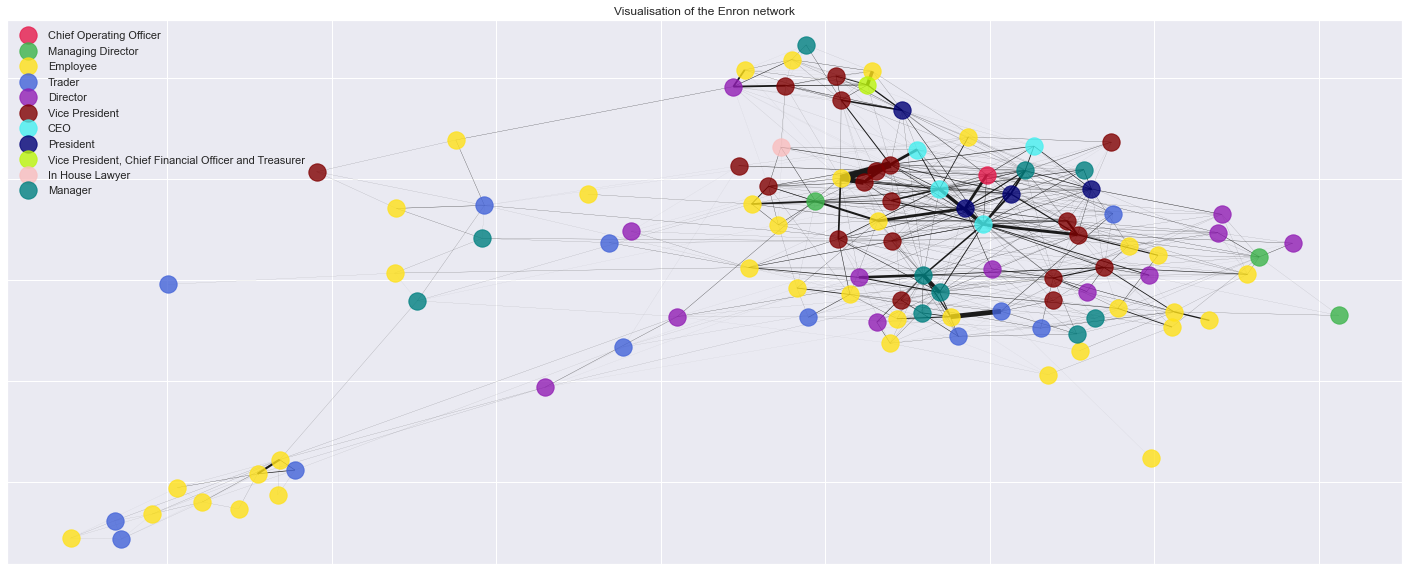

In [66]:
#edge width depending on the number of emails (weight attribute)
edge_widths = [H_und[u][v]['weight']/40 for u,v in H_und.edges()]

types = list(set(nx.get_node_attributes(H_und, "type").values()))
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', \
          '#911eb4', '#800000', '#46f0f0', '#000075', \
          '#bcf60c', '#fabebe', '#008080']
plt.figure(figsize=(25,10))

for i in range(len(types)):
    employee_type = types[i]
    nodes = [node for node in H_und.nodes() if H_und.nodes[node]["type"] == employee_type]
    node_color = colors[i]
    nx.draw_networkx_nodes(H_und, pos=positions, nodelist=nodes, node_color=node_color, label=employee_type, with_labels=False, alpha = 0.8)
    
nx.draw_networkx_edges(H_und,pos=positions, width = edge_widths)
plt.legend(scatterpoints=1, frameon = False)
plt.title("Visualisation of the Enron network")
plt.savefig('visualisation_enron_network.png')
plt.show()

Here, a visualization of the Enron-to-Enron network is presented. A number of interesting observations can be made:
* First, it is informtaive to find a small cluster of employees situtaed in the bottom-let side of the plot, who all have very low-degree and appear only affiliated with one another. Possibly, these individuals share division or physical location. The two nodes who are related to other individuals, could for instance be the unofficial leader of this group. As such, these reflections display how network science offers an interesting opportunity for human ressource departments to identify these unofficial leaders, when contemplating who should be assigned key positions in the future.
* Second, the placement of employees generally in the periphery displays another informative quality, resembling layman understanding of corporate structures. 
* Third, it appears that many traders has low-degree, one individual with a degree of 0. Possibly this reflects the roles in Enron, where communication with peers is not a key part of the job description for traders.

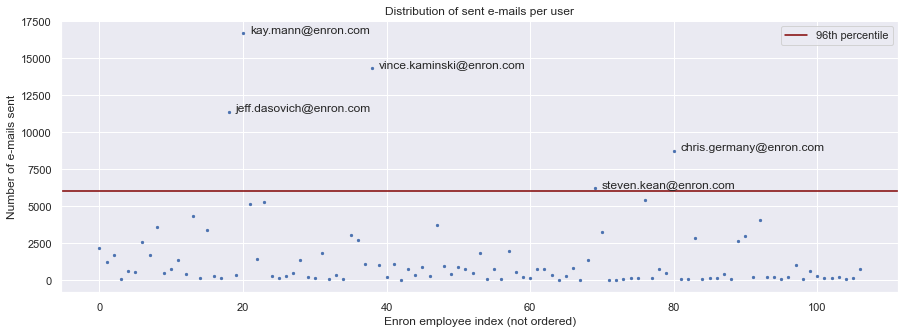

In [67]:
#Keep only Enron employees as senders
enron_senders_df = pd.merge(emails_df, jobs_df, how = 'inner', left_on='Sender Name', right_on='Name')
enron_senders_df = enron_senders_df.drop(columns=['Name'])

#only From column needed to compute the number of sent e-mails
enron_senders_df = enron_senders_df[['From']]

#dict with email:number of sent emails
from_counts = dict(Counter(enron_senders_df['From']))

from_emails = list(from_counts.keys())
nr_sent_emails = list(from_counts.values())

email_indices = [i for i in range(len(from_emails))]

plt.figure(figsize=(15,5))
plt.scatter(email_indices, nr_sent_emails, s=5)
percentile = 96
plt.axhline(y=np.percentile(nr_sent_emails, percentile), c="#800000", label=str(percentile)+"th percentile")
plt.legend()

#show emails of people who sent many e-mails
for n in email_indices:
    if nr_sent_emails[n] > np.percentile(nr_sent_emails, percentile):
        plt.text(x=n+1, y=nr_sent_emails[n], s=from_emails[n])
        
plt.title("Distribution of sent e-mails per user")
plt.xlabel("Enron employee index (not ordered)")
plt.ylabel("Number of e-mails sent")
plt.savefig('distribution_sent_emails_per_user.png')
plt.show()

This plot shows that most of Enron employees have sent less than 2500 e-mails, but there are a few outliers in the upper part for which the e-mails are shown.

The person at the of the plot is the one that sent most e-mails and it is Kay Mann - the head of legal for Enron. One could see some irony in this since the legal department was very active even though Enron is known for doing illegal business. Nevertheless, Kay Mann was not involved, only the top executives were found guilty.  

Vince Kaminski was Enron's managing director for research. His job was to perform mathematical analyses quantifying the potential risks and benefits of various business transactions. For months before Enron's demise, Vincent Kaminski warned superiors that the off-the-books partnerships and side deals were unethical and could bring down the company. As a manager, it is expected of him to send a lot of e-mails.

Jeff Dasovich was Enron's government relations executive and Steven Kean was Enron's former chief of staff. Therefore, it makes sense that they send a lot of e-mails.

### Calcultaing advanced network statistics

In the following, we will go into detail with the small network. We wish to see if the advanced network science measure can identify the key individuals of Enron, and if these indivduals are the same as the ones we have located in the above findings, i.e. Vince Kaminski, Kay mann and Jeff Dasovich. This will lead to to interesting discussions of how and why the methods and approaches differ.

We will:
* Analyze the betweeness, degree and eigenvector centrality of the network, looking into the first 5 identified people
* Compare the centrality measures
* Briefly investigate how network assortativity relates to these findings
* Display the communities of the network

## Centrality measures
Centrality metrics offers a valuable and informative view into the centrality of a node x, i.e. how many other nodes are related to node x. The different metrics are calculated in different ways:

#### Betweenss centrality
Betweeness centrality computes the probability for a node x, to occur on another random nodes path through the graph. As such, if the probability of occurence is high, the node can be identified as a central node

In [ ]:
b_centrality = nx.betweenness_centrality(H)
b_centrality = {k:v for k,v in sorted(b_centrality.items(), key=lambda item:item[1], reverse=True)}
b_top5 = list(b_centrality.keys())[0:5]
b_top5 = str(b_top5)[1:-1] #This just to ensure that the printing statement doesn't include brackets
print(f"The 5 most central characters according to betweeness centrality are \n{b_top5}")
b_centrality1 = nx.betweenness_centrality(G)

#### Degree centrality
Degree centrality offers the simplest understanding of centrality, which is just the number of edges node x has. 

In [ ]:
cen = nx.degree_centrality(H) #Keeping this for when an unordered set is nesscesary
centrality = nx.degree_centrality(H)
centrality = {k:v for k,v in sorted(centrality.items(), key=lambda item:item[1], reverse=True)}
top5 = list(centrality.keys())[0:5]
top5 = str(top5)[1:-1] #This just to ensure that the printing statement doesn't include brackets
print(f"The 5 most central characters according to degree centrality are \n{top5}")

#### Eigenvector centrality
The Eigenvector centrality calculates a score for each node in a network, depending on the specific nodes edges to other nodes with high-degree. 

In [ ]:
eig_cen = nx.eigenvector_centrality(H)
eig_cen ={k:v for k,v in sorted(eig_cen.items(), key=lambda item:item[1], reverse=True)}
eig_top5 = list(eig_cen.keys())[0:5]
eig_top5 = str(eig_top5)[1:-1] #This just to ensure that the printing statement doesn't include brackets
print(f"The 5 most central characters according to eigenvector centrality are \n{eig_top5}")
eigcen1 = nx.eigenvector_centrality(G)

Visualising the correlations betweeness degree centrality and eigenvector and betwenss centrality, respectively.

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].scatter(b_centrality1.values(), cen.values(), c="green", alpha=0.7)
axes[0].set_title("Correlation: Betweeness centrality and degree centrality")
axes[0].set_xlabel("Betweeness Centrality")
axes[0].set_ylabel("Degree Centrality")
axes[0].set_ylim(0,1)
axes[0].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_xlim(0,1)
axes[1].scatter(eigcen1.values(), cen.values(), c="purple", alpha=0.3)
axes[1].set_ylabel("Degree Centrality")
axes[1].set_xlabel("Eigenvector centrality")
axes[1].set_title("Correlation: Eigenvector centrality and degree centrality")
plt.savefig("C:/Users/marti/Desktop/Correlations.png")

To further analyze the different centrality measures, we have computed the correlation between the degree centrality and eigenvector and betweenness centrality, respectively. We observe the expected pattern, i.e. a strong, positive correlation between degree and eigenvector centrality - this appear as expected since these two metrics identified the exact same 5 individuals.
It is, however, interesting to find that the betweness centrality measure differs from the two others. Possibly this can be attributed to the fact that the betweenss measure is less sensitive to nodes with high-degree, than the two other measures. 

#### Calculating degree assortativity


In [ ]:
degree_assortativity = nx.degree_assortativity_coefficient(H)

In [ ]:
print(degree_assortativity)

As the final part of this network science module, we would like to briefly touch upon degree assortativity, which can be understood as the tendency for nodes to mix with nodes that share degree. We observe a slight, positive degree assortativity of 0.2, meaning that a only small tendency for nodes to connect to other nodes with similar degree, can be identified. The finding of a assortativity score close to 0 underpins the nature of an organization, since people of varying communication needs (i.e. high and low degree nodes), are required to stay in touch with one another. As such, this finding affirms our conclusion found above (regarding the dispersion of communities).

#### Displaying community sizes

At this point, it would be interesting to see if communities resembling the hierarchy of Enron, could be identified. One could have a hypothesis that people inhabiting comparable occupation category would tend to be more closely related to one another. At the time same, one could also hypothesize that people, in a complex, fast-changing organization like Enron, would need to stay in touch with multiple different people, from different roles; thus, communities resembling occupation categories would need not possible to identify.

Here, we applied the Louvain detection algorithm, and found 8 communities:

In [ ]:
sns.set()
distribution_community_sizes = dict(nltk.FreqDist(partition.values()))
communities = list(distribution_community_sizes.keys())
sizes = list(distribution_community_sizes.values())
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.title('Distribution of Community Sizes', size=18)
plt.xlabel('Community number')
plt.ylabel('Community size')
plt.bar(communities, sizes)
plt.savefig("C:/Users/marti/Desktop/Communities.png")
plt.show()

#### Overview statistics for employees in different communities

In [ ]:
a = [i for i,j in partition.items() if j==3]
a

In [ ]:
b = [j for i,j in partition.items() if i=="kay.mann@enron.com"]
b

In [ ]:
c = [j for i,j in partition.items() if i=="jeff.dasovich@enron.com"]
c

A read through the nodes in each community draws our attention to mainly community 2 & 3, as community2 is inhabited by (among others) Philliph Alllen and Mike Grigsby, while in community3 we locate John Lavorato, Jeff Skilling, Vince Kaminski & David Delainey. As such, we observe a slight tendency for the communicative key-people to cluster themselves together. However, Kay Mann is found in community 4 while Jeff Dasovich resides in 5. The pattern of our key people to be situated in different communities, has likely to do with the fact that in order to lead a large corporation like Enron, with multiple different subdivisions doing vastly different things, one needs communicative centers many places in the organization; as such, our analysis indicates that Enron is not a corporation which is managed strongly from the top; more, we find a tendency for the managers to be situated in different branches of the organization. As a future note, it would be very interesting to see if the communities resemble different physical locations of Enron, i.e. an office in city X and an office in city Y, as this would provide further evidence of our insinuations. This, unfortunately, exceeds the scope of this analysis.

# Part 3.2 - Natural Language Processing (NLP)

The NLP part of this project has two main focus points. 
* The first is to compare the language use across different levels in the organisation. This includes both sentiment and content. 
* The second is to examine if / how these change over time, as the company Enron comes closer to the date of bankruptcy. 

Investigating this development over time, is particulary interesting, because the bankruptcy downfall was a consequence of fraud - perhaps it is possible to detect an increasingly negative mood in the organisation as time passes.  

## Basic stats for NLP-part 

Here we look into how many e-mails and employees there are from each level, and the average amount of e-mails from each level. 

In [227]:
#Distribution of employees and e-mails across the layers
h = ['Top','Middle','Lower']
LstatWork = {}
LstatMails = {}

for hi in h:
    print(hi)
    LstatWork[hi] = len(list(set(small[small['Hierachy']==hi].Name)))
    LstatMails[hi] = len(small[small['Hierachy']==hi].Content)
    print(f'People: {LstatWork[hi]}, Number of e/mails in total: {LstatMails[hi]}, Average e-mail per person: {LstatMails[hi]/LstatWork[hi]}')
    print('\n')

Top
People: 25, Number of e/mails in total: 22921, Average e-mail per person: 916.84


Middle
People: 29, Number of e/mails in total: 50994, Average e-mail per person: 1758.4137931034484


Lower
People: 50, Number of e/mails in total: 83666, Average e-mail per person: 1673.32




We see that there are more people in the lower level than the Middle and Top-level, which makes sense. The amount of e-mails is also bigger for the Lower-level. The Mid-level sends the most e-mails per person, which makes sense as the probably need to reach out to both people above and below them. It can also be seen in the Force Atlas visualisation of the small network, that people with these Job-titles are well connected across the organisation. 

### Simple language-related statistics 

The first part of the language analysis includes some simple statistics on the raw content of the e-mails. The goal is to get a preliminary insight in the language use among the three employee levels and compare them. We are curious to the extend of e-mails correspondences from each level and hope to get an idea about how much the e-mail content gives the first impression of being professional, high-level language suited for this type of fancy company, or if it is dominated by casual / sloppy talk and written slang. The tools to use for this includes some key figures that was introduced in week 6 such as 
* Length of documents
* Average length of words
* Longest word
* Vocabulary
* Lexical diversity 
* Longest word

Furthermore we have calculated the average LIX-number for each of the levels by $$ \frac{Number  of words}{Number  of periods/colons} + \frac{Number of words > 6 letters \cdot 100}{Number of words}  $$

These figures are calculated in a function that returns a dictionary with each value. The input is a tokenized string.  

###### Function for simple statistics

In [1]:
def stat_func(ListOfTokens):
    stats = {}
    
    OnlyLetters = [token.lower() for token in ListOfTokens if token.isalpha()] #Only word-tokens
    OnlyPunct = [char for char in Corpus['Top'] if char == '.'] #Only punctuations
    OnlyLong = [token for token in OnlyLetters if len(token) > 6] #Only long words
    
    ListOfLengths = [len(token) for token in OnlyLetters] #length of each word
    
    A = len(OnlyLetters)
    B = len(OnlyLong)
    C = len(OnlyPunct)
    
    stats['Length'] = len(ListOfTokens)
    stats['Vocab'] = len(set(OnlyLetters))
    stats['Average'] = np.mean(ListOfLengths)
    stats['Longest word'] = max(OnlyLetters, key=len)
    stats['Lexical diversity '] = len(set(OnlyLetters)) / A *100 
    stats['Lix'] = A/B + C*100/A
    
    return stats

In [83]:
print('Top',stat_func(Corpus['Top']))
print("\n")
print('Middle',stat_func(Corpus['Middle']))
print("\n")
print('Lower',stat_func(Corpus['Lower']))

Top {'Length': 265009, 'Vocab': 5823, 'Average': 3.809199067499129, 'Longest word': 'miscommunication', 'Lexical diversity ': 3.9008279964629278, 'Lix': 11.999635823551799}


Middle {'Length': 589012, 'Vocab': 9948, 'Average': 3.8240594022920735, 'Longest word': 'wooooooooooooooooooooohooooooooooooooooooooooo', 'Lexical diversity ': 3.0548697350480896, 'Lix': 9.998498804056299}


Lower {'Length': 963861, 'Vocab': 13734, 'Average': 3.841828855599351, 'Longest word': 'joooooooooooooooooninnnnnnnnnnnnnnnnniiiiiiiii', 'Lexical diversity ': 2.5522804943998127, 'Lix': 9.233893574759238}


A big difference in terms of document length is noted, with the lower level having the longest and the top level having the shortest, likely explained by the number of people. The vocabulary is larger for the middle and lower level, which makes sense as the document is about three times the lenght. Overall the lexical diversity and lix numbers are low although slightly increasing when moving upwards in the organisation. Also noted is that the top-level's longest word is a proper word, whereas it seems that the middle and lower level is just fooling around. Thus it is indicated here, that the written communication might be more serious among the top level in Enron.

## Word-tagging and frequency distribution

The next part of examining the language across the organisation-hierachy involves tagging the tokens as suggested in NLTK Book chapter 5, and creating a frequency distribution for each of the levels. Here the focus is simply on substantives, verbs and adjectives. The idea is that by dividing the frequency distribution into word-classes we get a better insight into how the people in the different levels work. The procedure is as follows: 
* Tag each of the tokens
* Create three dictionaries, one for nouns, verbs and adjectives that contain all the words with those tags for each layer
* Create a frequency distribution plot for each wordtype, each job-level and compare

In [ ]:
import nltk.corpus  
from nltk.text import Text
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
mport matplotlib.pyplot as plt

In [ ]:
#Tagging the tokens
tagged_tok = {k:pos_tag(tokensD[k]) for (k,v) in tokensD.items()}

In [ ]:
#Dictionaries of Noun, Verbs and Adjectives for each layer
Nouns = {}
Verbs = {}
Adjs = {}

for hi in h:
    Nouns[hi] = [w for w,tag in tagged_tok[hi] if tag.startswith('NN')]
    Verbs[hi] = [w for w,tag in tagged_tok[hi] if tag.startswith('VB')]
    Adjs[hi] = [w for w,tag in tagged_tok[hi] if tag.startswith('JJ')]

###### Plot of Nouns

Plot of frequence distribution for nouns


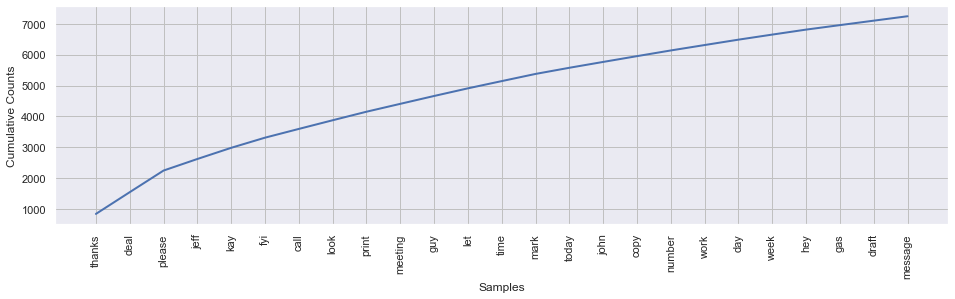

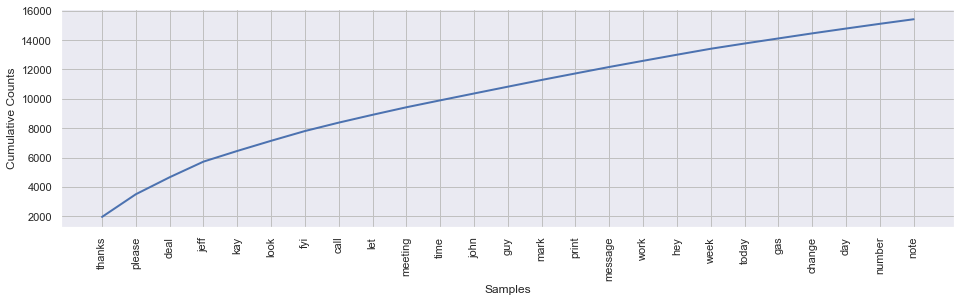

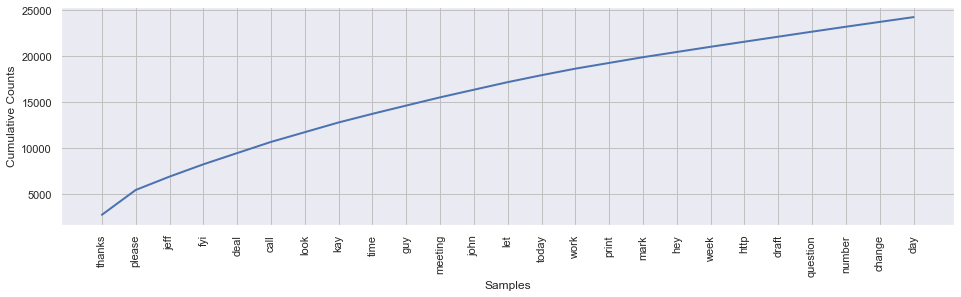

In [245]:
fdistT = FreqDist(Nouns['Top'])
fdistM = FreqDist(Nouns['Middle'])
fdistL = FreqDist(Nouns['Lower'])
print('Plot of frequency distribution for nouns')
plt.figure(figsize=(16, 4))
fdistT.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistM.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistL.plot(25, cumulative = True)


First we see that the pos_tag function did a questionable job of tagging the Nouns, as for example multiple names are included. Other words such as 'work' or 'call' the context is needed wether to justify the correctness. However assuming they are correct and looking into the distribution across the levels, many of the words occur all places, and it is not possible to identify which are most likely to belong to each level. 
Some deductions valid for all three levels are: 
* Pretty casual language in the organisation such as 'fyi', 'kay', 'hey' or 'guys'. 
* All three levels are likely talkin about the CEO 'Jeff' Skilling. 
* Thanks and please are very dominating for all three - showing the polite / professional office/language.

Some small differences among the three levels are identified as 
* The 'http' in lower level, indicates that these people are sharing links with each other.
* 'Draft'in the lower level can be associated to the typical work tasks at that level in the organasation. Probablt the top executives has secretaries etc. to make drafts for them. 

###### Plot of verbs

Plot of frequency distribution for Verbs


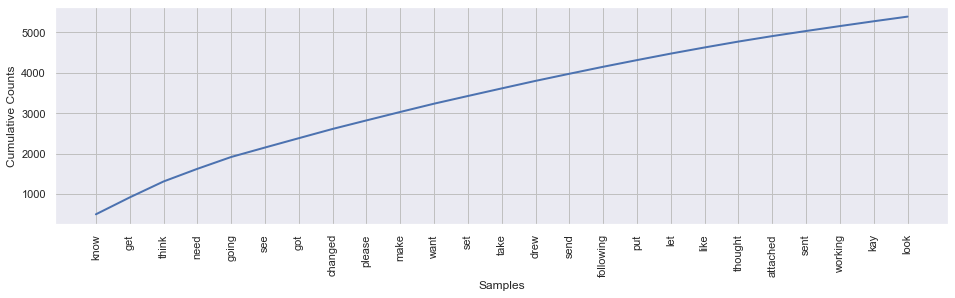

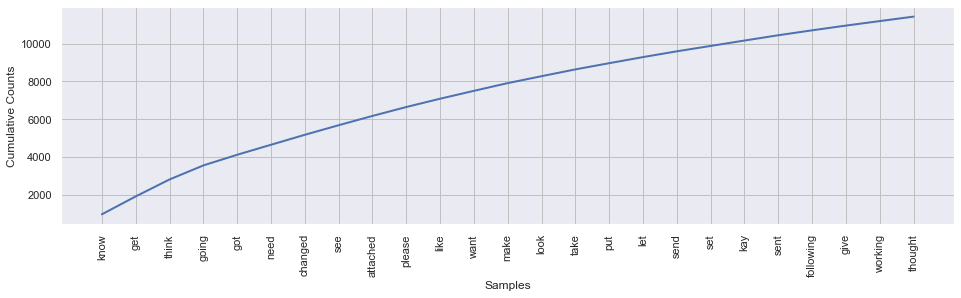

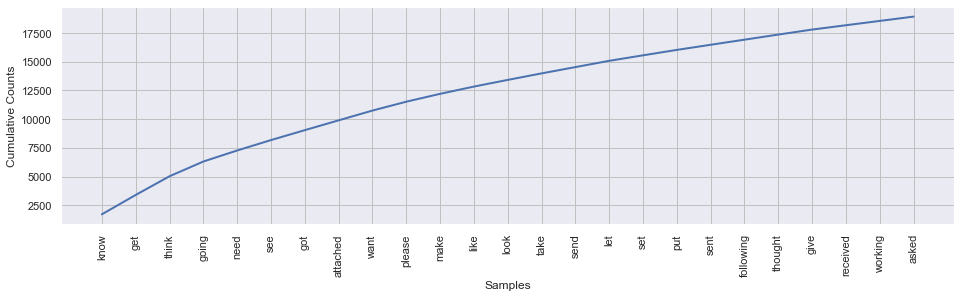

In [256]:
fdistT = FreqDist(Verbs['Top'])
fdistM = FreqDist(Verbs['Middle'])
fdistL = FreqDist(Verbs['Lower'])
print('Plot of frequency distribution for Verbs')
plt.figure(figsize=(16, 4))
fdistT.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistM.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistL.plot(25, cumulative = True)

This time the pos_tag did a better job in tagging the words, only the inclusion of 'please' being wrong. Apart from that, it is still hard to distinguish the three levels. Many of the same generic words occur, such as 'think', 'know' and 'get', which are common in most situations. However some small differences are pointed out below:

* 'Attached' has a higher frequncey among the mid- and lower-level - these functions could be sending more files to collegues than the top/level, which seems plausible.
* The top-level includes 'Drew' which doesn't occur on the other levels. 
* The lower level includes 'recieved' and 'asked' that doesn't occur in the mid- and top-level.   

###### Plot of adjectives

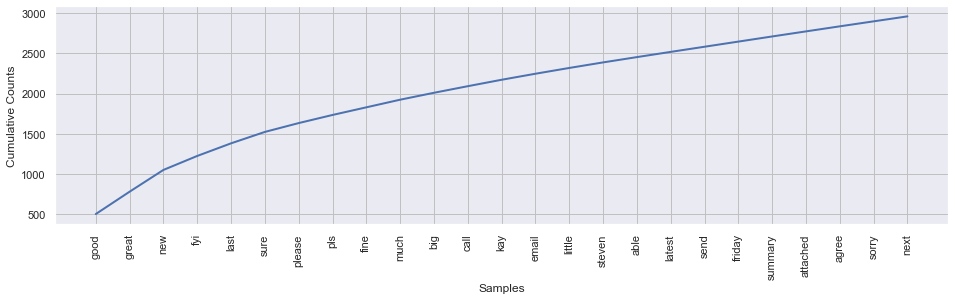

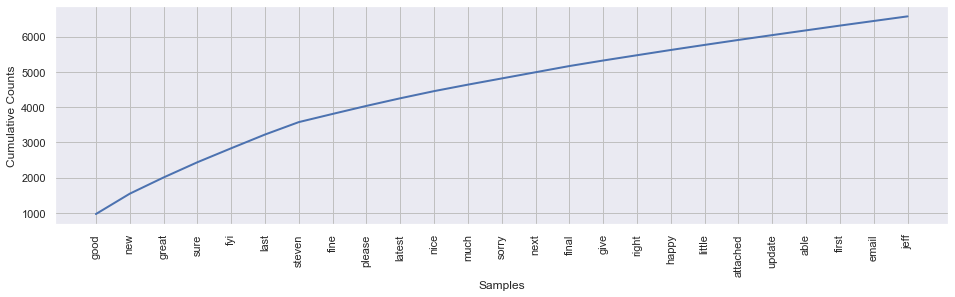

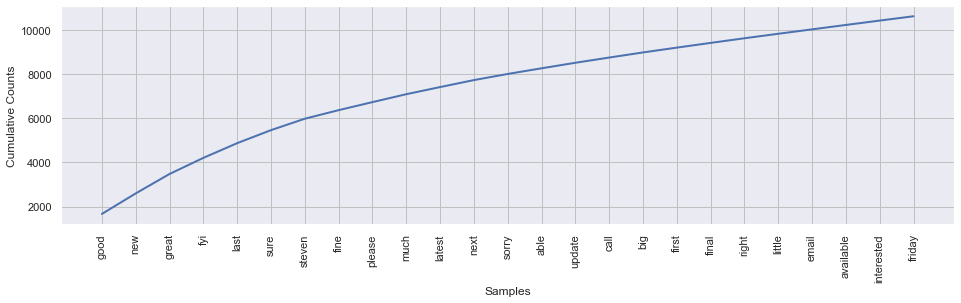

In [258]:
fdistT = FreqDist(Adjs['Top'])
fdistM = FreqDist(Adjs['Middle'])
fdistL = FreqDist(Adjs['Lower'])
plt.figure(figsize=(16, 4))
fdistT.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistM.plot(25, cumulative = True)
plt.figure(figsize=(16, 4))
fdistL.plot(25, cumulative = True)

Again the output is rather generic. The pos_tag is making several mistakes when identifying adjectives. Many of the most frequent words are shared between the three levels. Some differences to point out are: 
* Sorry is more frequent for mid-level and lower-level employees. Perhaps people in high level positions feel less need for that. 
* The mid-level are the only people where 'happy' is among the most frequent 25 words. 
* It is only among the lower-level that 'available'occurs'. 

Overall the attempt with the pos_tag function was a questionable success. The ability to tag words was better for verbs than for Nouns or Adjectives. This could have something to do with that verbs take more forms that are easier do identify for example the ing-form. Only few meaningful deductions were possible. Some ways to improve this for a more in-depth analysis, could be 
* Different definitions of the organisational levels, perhaps even more specified. 
* Examining the contexts of the words that might shows that the message is different among the levels.
* Identifying which words that are used in a similar way, and replace them with just one word. This way we could have cleaned out for example both 'good', 'great' and 'nice'. 

### TF-IDF based Word clouds

In this section we calculate TF-IDF for every level for the purpose of identifying both which words occur a lot within each level, and which words that are special for each of the levels. This will also be the input for word-clouds. 
* We first calculate the Term frequency based on the raw count. 
* Calculate TF accounted for document length, augmented frequency and logarithmically scaled. 
* Choose one to present for each level.
The raw serves as a baseline model for other types of TF-IDF calculations, and as motivation to choose alternatives. 

In [120]:
#Dictionary with raw counts
TF_Jobs = {}
for job in tokensD.keys():
    fdist = dict(nltk.FreqDist(tokensD[job]))
    #sort
    TF = {k: v for k, v in sorted(fdist.items(), key=lambda item: item[1],reverse=True)}
    TF_Jobs[job] = TF

In [121]:
print('Top', list(TF_Jobs['Top'].items())[0:10])
print('Middle',list(TF_Jobs['Middle'].items())[0:10])
print('Lower',list(TF_Jobs['Lower'].items())[0:10])

Top [('please', 1021), ('thanks', 860), ('deal', 772), ('kay', 593), ('fyi', 577), ('know', 553), ('get', 547), ('would', 522), ('good', 510), ('need', 482)]
Middle [('please', 2246), ('thanks', 1998), ('deal', 1309), ('jeff', 1260), ('fyi', 1251), ('get', 1212), ('would', 1210), ('kay', 1182), ('know', 1134), ('like', 1104)]
Lower [('please', 3852), ('thanks', 2771), ('fyi', 2423), ('get', 2193), ('think', 1985), ('know', 1981), ('would', 1929), ('call', 1749), ('need', 1728), ('good', 1715)]


Here we notice many common words such as 'please' and 'thanks', which makes sense in a professional environment and we recognize from the pos_tag analysis. We also identify some people, top level is speaking about a 'John', the middle a 'Steven' and the lower level 'Jeff' which could very well be the CEO. There's a difference in occurence which is explained by the difference in document length. This motivates to account for document size when calculating TF-IDF's to make meaningful word-clouds. It is also seen that the 1-2 most used words for each level, is used quite a bit more than the rest in Top10. This motivates for calculating and comparing with the 'Augmented Frequency'. Lastly it is seen that some words are used only 1 time, which makes the difference between the most and least used words quite large. This motivates for using the logaritmically scaled frequency. 
These are calculated, but despite hopes resulted in rather similar word-clouds. Therefore the word clouds adjusted for document length is presented in the project. 

#### TF-IDF adjusted for document length

#### Term Frequency adjusted for document length
The Term frequency adjusted for document length is calculated by: $$tf(t,d) = ft,d ÷ (number of words in d)$$ and the IDF is chosen to be calculated as: 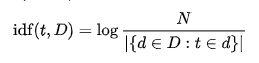$$ INDSÆT FORMEL$$

In [259]:
#Calculating TF dictionary
TFd_Jobs = {}
for job in tokensD.keys():
    fdist = dict(nltk.FreqDist(tokensD[job]))
    l = len(tokensD[job])
    TFd = {k: v/l for k, v in fdist.items()}
    TFd_Jobs[job] = TFd

In [260]:
#Create IDF dictionary for each job
IDF_Jobs = {}
N = len(tokensD.keys())

for job in tokensD.keys():
    idf = {}
    for string in tokensD[job]:
        occurence_in_other_docs = 0
        for others in tokensD.keys():
            if string in TF_Jobs[others].keys():
                occurence_in_other_docs += 1
        idf[string] = math.log(N/1+occurence_in_other_docs)
    IDF_Jobs[job] = idf

In [261]:
#Putting it together to TF-IDF
TFIDF_D = {}
for job in tokensD.keys():
    tfidf = {}
    for string in tokensD[job]:
        tfidf[string] = TFd_Jobs[job][string] * IDF_Jobs[job][string]
    TFIDF_D[job] = tfidf
    TFIDF_D[job] = {k: v for k, v in sorted(TFIDF_D[job].items(), key=lambda item: item[1],reverse=True)}

#### Word clouds

The word clouds are created as in Week 7, where the TF-IDF score is rounded to nearest integer value and multplied with the token-string. Secondly we have included a random_state, so that it was easiest possible to compare the different word-clouds, we have also chosen to only show words of minimum length 4 in an attempt to reduce noise. 

In [262]:
#First making a list of strings for each document
Jobs_lists = {}
for job in TFIDF_D.keys():
    el = [(text+' ')*(round(TFIDF_D[job][text]+1)) for text in TFIDF_D[job]]
    Jobs_lists[job] = el

Jobs_strings = {}
for job in TFIDF_D.keys():
    st = ' '.join(Jobs_lists[job])
    Jobs_strings[job] = st

Top


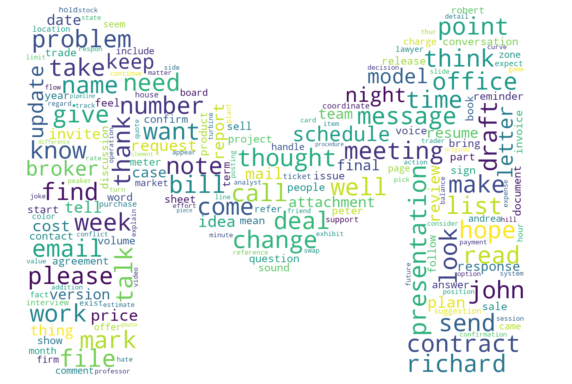

Middle


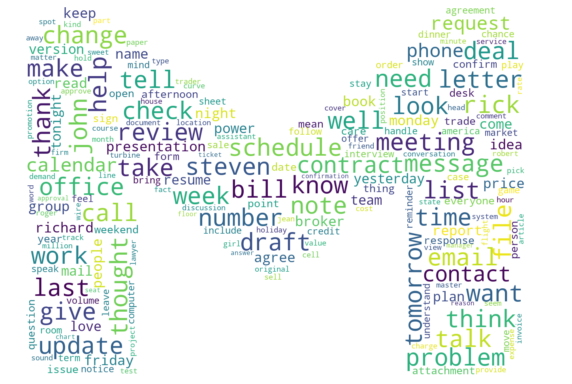

Lower


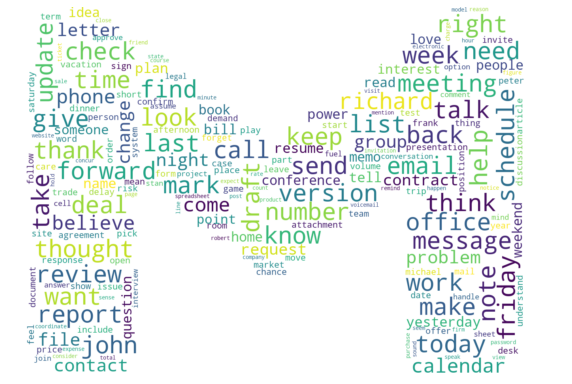

In [272]:
#create the Wordclouds
for job in Jobs_strings.keys():
    print(job)
    plt.figure(figsize=(10, 10))
    wc = WordCloud(collocations=False, max_font_size = 60,random_state = 40, background_color="white", min_word_length = 4,mask=mask).generate(Jobs_strings[job])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

It is rather difficult to identify a difference between the three levels, as there are many overlaps despite not using the raw count. The points mentioned in the pos_tag analysis to achieve better results very much also applies here. 
The Word-Clouds are used as an off-set for disperson plot. So for each level, some words are chosen that could be interesting to present in a dispersion plot in the next section. 

### Dispersion - plots

Here we look into the word density. When creating the tokens, the e-mails were put together in cronological order. A word-offset is of course not completely equivalent to the time, but the density can still give a hint about what the employees were talking about over the period. And it is very useful for seeing which words were relevant around the same time. 

#### Density plot for Top-level

In [274]:
Top = nltk.Text(tokensD['Top'])

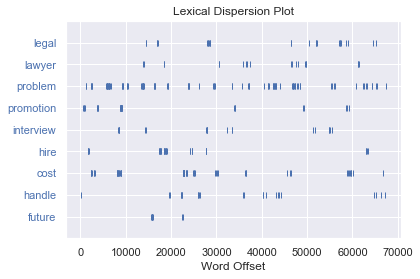

In [277]:
Top.dispersion_plot(["legal", "lawyer", "problem", "promotion", 'interview', "hire","cost", 'handle', 'future'])

Some interesting points to take from the plot is that 
* the density of legal and lawyer are quite similar, which makes sense intuitively. Especially legal is rather mentioned in the last e-mails. 
* hire and promotion was relevant in some of the last e-mails in the data set, and also the first. 
* cost seems to be mentionded in chunks, perhaps some big expenses at that point. 
* problem is well distributed over the entire period, which makes good sense in a company. 
* The top-level only writes about the future in the first emails.

In [278]:
Mid = nltk.Text(tokensD['Middle'])

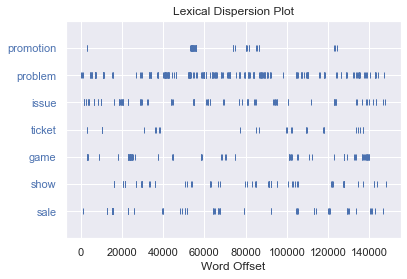

In [281]:
Mid.dispersion_plot(["promotion", "problem", "issue", "ticket","game","show", "sale"])

* Compared to the top-level the word problem has a higher density for the mid-level across all of the e-mails. Íssue' follows this pattern. 
* It is seen that promotion was mentioned a lot in the middle of the period and less in the ends, opposed to the top-level. 
* Ticket, game, and show indicate private e-mails or after work socialising which seems to be relevant across all of the e-mail. Particularly game is dense towards the end. 

In [236]:
Low = nltk.Text(tokensD['Lower'])

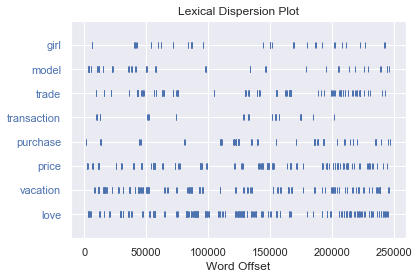

In [284]:
Low.dispersion_plot(["girl", "model", "trade", "transaction", "purchase","price",'vacation','love'])

### Sentiment analysis

In [99]:
metrics = 'C:/Users/Hidde/Downloads/wordlist.txt' 
df = pd.read_csv(metrics, delimiter= '\t', names=["word","happiness_rank","happiness_average","happiness_standard_deviation","twitter_rank","google_rank","nyt_rank","lyrics_rank"])
df = df.iloc[2:] #The first two rows of the dataframe are the title and subtitle of the document, thus these are skipped

The following function is a copy from assignment 2, it calculates the sentiment for a list of tokens. 

In [100]:
def sentiment(tokenlist):
    c = 0
    score = 0
    tokenlist = list(set(tokenlist))
    for token in tokenlist: 
        if token in list(df.word):
            score=score+float(df.loc[df.word==token]['happiness_average'].values)
            c = c+1
    if c > 0:
        ave = score/c
    else:
        ave = 5
    return ave

#### Overall sentiment analysis for each jobtype

First we examine wether there is a difference between the overall sentiment for in group. The procedure is to first extract all unique tokens in each of the three documents, and next to calculate the sentiment using the function from assignment 2. 

In [101]:
#Dictionary of unique tokens
uniq = {k:set(v) for (k,v) in tokensD.items() }

#Dictionary of sentiment for each level
SentO = {k:sentiment(v) for (k,v) in uniq.items()}

In [102]:
SentO

{'Top': 5.515476353666894,
 'Middle': 5.508379343169911,
 'Lower': 5.474055848467096}

All three levels are overall rather neutral, which can be expected for two likely reasons. 
* 1) The documents are long. 
* 2) It is a professional environment. 

However, it does seem that the sentiment increases (slightly) as we go up in level, and that the e-mails aggregated become more happy, the higher the level in the organisation-hierarchy. 

### Sentiment analysis over time

#### Sentiment per day over the entire period

Next we will make use of the knowledge about when the e-mails were sent, and calculate the sentiment of each level for every day there was e-mail activity in the period. This is done by creating a dictionary for each job-level, where the dates are the keys and the values are the sentiment. This format was chosen as not every level has e-mail correspondencies on each day. 

In [103]:
Topdf = small1.loc[(small1['Hierachy']=='Top')]
Topdf = Topdf.reset_index(drop=True)
Topdf['Cleaned'] = Topdf.groupby(['Day-month-year'])['Cleaned'].transform(lambda x : ' '.join(x))
UniqueT = Topdf.drop_duplicates(subset=['Cleaned'])

Middf = small1.loc[(small1['Hierachy']=='Middle')]
Middf = Middf.reset_index(drop=True)
Middf['Cleaned'] = Middf.groupby(['Day-month-year'])['Cleaned'].transform(lambda x : ' '.join(x))
UniqueM = Middf.drop_duplicates(subset=['Cleaned'])

Lowdf = small1.loc[(small1['Hierachy']=='Lower')]
Lowdf = Lowdf.reset_index(drop=True)
Lowdf['Cleaned'] = Lowdf.groupby(['Day-month-year'])['Cleaned'].transform(lambda x : ' '.join(x))
UniqueL = Lowdf.drop_duplicates(subset=['Cleaned'])

In [104]:
UniqueT = UniqueT.reset_index(drop=True)
UniqueM = UniqueM.reset_index(drop=True)
UniqueL = UniqueL.reset_index(drop=True)

In [105]:
# Calculating (average) sentiment for each day for Top-level
MidSent = {}
LowSent = {}
TopSent = {}

for m in range(0,len(UniqueT)):
    T = word_tokenize(UniqueT.Cleaned[m])
    ReadyForSent = clean(T)
    date = UniqueT['Day-month-year'][m]
    TopSent[date] = sentiment(ReadyForSent)

for m in range(0,len(UniqueM)):
    T = word_tokenize(UniqueM.Cleaned[m])
    ReadyForSent = clean(T)
    date = UniqueM['Day-month-year'][m]
    MidSent[date] = sentiment(ReadyForSent)

for m in range(0,len(UniqueL)):
    T = word_tokenize(UniqueL.Cleaned[m])
    ReadyForSent = clean(T)
    date = UniqueL['Day-month-year'][m]
    LowSent[date] = sentiment(ReadyForSent)

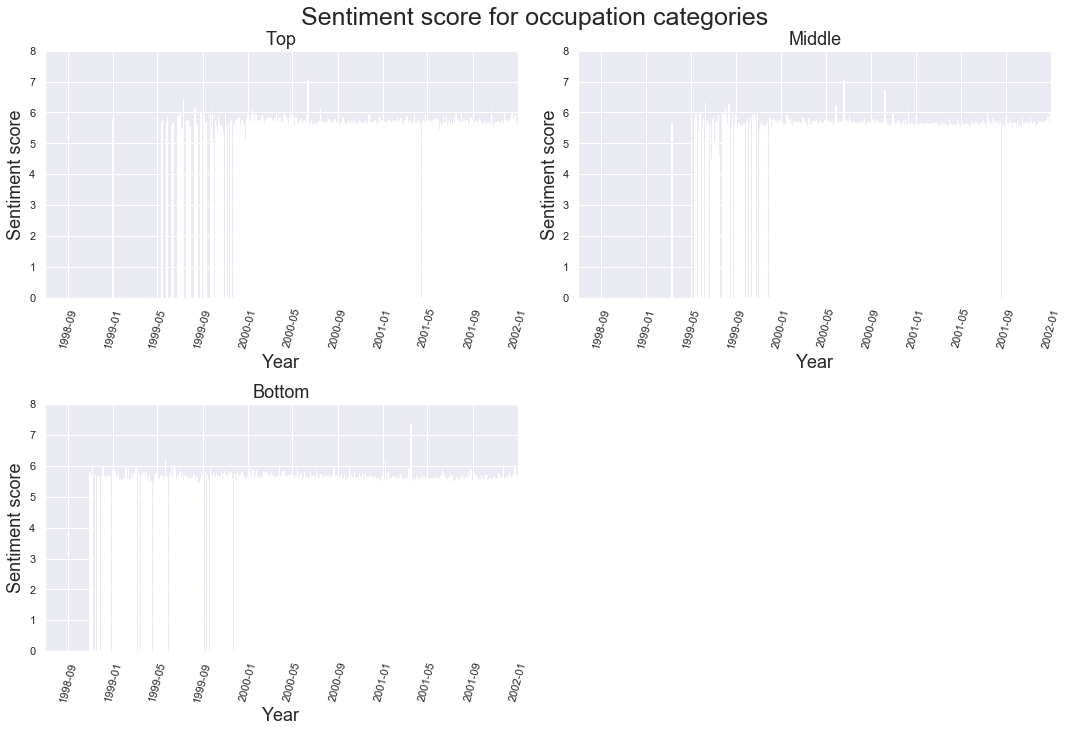

In [218]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
sns.set()
axes = axes.flatten()
axes[0].bar(x = list(TopSent.keys()), height = TopSent.values(), color='red')
axes[0].set_title('Top', size=18)
axes[1].bar(x = list(MidSent.keys()), height = MidSent.values(), color='red')
axes[1].set_title('Middle', size=18)
axes[2].bar(x = list(LowSent.keys()), height = LowSent.values(), color='red')
axes[2].set_title('Bottom', size=18)

for i, ax in enumerate(axes.flat):
    ax.set_xlim(datetime.date(1998,7,1),datetime.date(2002,1,1))
    ax.tick_params(axis='x', labelrotation=75)
    ax.set_ylabel('Sentiment score', size=18)
    ax.set_xlabel('Year', size=18)
    ax.set_ylim(0,8)

fig.suptitle('Sentiment score for occupation categories', y=1.015, size=25),
    
n = 30
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n !=0]
fig.tight_layout()
fig.delaxes(axes[3])
plt.savefig('Sentiment scores for occupatio categories')

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
sns.set()
axes = axes.flatten()
axes[0].bar(x = list(TopSent.keys()), height = TopSent.values(), color='red')
axes[0].set_title('Top', size=18)
axes[1].bar(x = list(MidSent.keys()), height = MidSent.values(), color='red')
axes[1].set_title('Middle', size=18)
axes[2].bar(x = list(LowSent.keys()), height = LowSent.values(), color='red')
axes[2].set_title('Bottom', size=18)

for i, ax in enumerate(axes.flat):
    ax.set_xlim(datetime.date(1998,7,1),datetime.date(2002,1,1))
    ax.tick_params(axis='x', labelrotation=75)
    ax.set_ylabel('Sentiment score', size=18)
    ax.set_xlabel('Year', size=18)
    ax.set_ylim(0,8)

fig.suptitle('Sentiment score for occupation categories', y=1.015, size=25),
    
n = 30
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n !=0]
fig.tight_layout()
fig.delaxes(axes[3])
plt.savefig('Sentiment scores for occupatio categories')

The plot of the sentiment score identifies some peaks. For both Top and Middle these occurs in the last half of 2000, which is around that period where the stock-prices are peaking. This does however not seem to affect the lower level very much, that seems to have a delayed effect as they peak in the beginning of 2001 - right before things starts going wrong. 
It is expected that the average sentiment score is very average, as there are so many documents that are aggregated, and that it in the end is a professional company. Further analysis to be done could have been exploring the sentiment distribution over the weekdays, or identify the individuals who are the most / least happy.  

# Disease modelling
In the following, disease modelling on various networks will be investigated. We will explore 3 different networks, 1) 1% of the total Enron network, 2) Enron-to-Enron network, and 3) the old superhero network.
These 3 networks has been chosen, as they combined offer a very informative view of how disease spreading is vitally dependent on node-degree. We have chosen the S-I-R approach, which holds the vital assumption that nodes are unable to contract the disease a second time - they remain immune after infection, if they have survived the disease.

S-I-R relates to the infection status of nodes/individuals in a network, which can take on a qualities of susceptible (S), infected (I) and recovered (R). A array of similar models can be outlined, for instance, the S-I-R-S approach, which posits that nodes become susceptible at a given time interval after they recovered (Let's not hope this is the case for Covid-19!). 
We have chosen the S-I-R approach, as it best resembles the disease cycle of Covid-19, according to reserachers.


## Now for the infection modelling part
The infection modelling occurs in the following steps:
* First, all nodes are made susceptible, set as an attribute
* A random node is infected
* In the first iteration, this node is able to infect his/her peers at infection probability of 10%
* In the following iterations (up to 100), the model finds all infected nodes, and let them infect their neighbors at the given infection probability
* For the small network only, we also compute the number of S, R and I in each community.
* If the nodes has been infected for 10 iterations, they recover
* At the end of each itteration, a count is made summing up the amount if S, R and I. This information is stored in a dictionary, keyed by timestamp. 

As we will be producing gif-files in this code (which were hard to display in the Jupyter notebook), we invite the reader to view these on the website, as this will give the best reading experience

In [ ]:
#Making all nodes suseptible for infection
nx.set_node_attributes(G, "susceptible", "status")
#Setting time attribute, to keep track of where nodes are in infection-cycle
nx.set_node_attributes(G, 0, "time_infected")
partition = community.best_partition(G) ## Setting node community, to identify development of infection status according to community
nx.set_node_attributes(G, partition, "Community")

### Modelling on the 1% of big enron network

First, we performed the analysis on 1% of the big enron network. We choose 1% as an analysis of the full network was not possible to run on our computers, while just using 1% clearly displays the same characteristics as the full version would have done. We genuinely apologize for the length of this code. In the future, a more concise approach would definetely be to make a function!

In [ ]:
#To use 1% of total Enron network:
df = pd.read_csv("C:/Users/marti/Desktop/pandas_full.csv")
df = df.sample(frac=0.01)
G = nx.from_pandas_edgelist(df=df, source='From', target='To', edge_attr='number of e-mails', create_using=nx.DiGraph())

In [ ]:
#Making all nodes suseptible for infection
nx.set_node_attributes(G, "susceptible", "status")
#Setting time attribute, to keep track of where nodes are in infection-cycle
nx.set_node_attributes(G, 0, "time_infected")
partition = community.best_partition(G) ## Setting node community, to identify development of infection status according to community
nx.set_node_attributes(G, partition, "Community")

In [ ]:
#setting parameters
infection_probability = 0.1
steps = range(100)
time_to_recover = 10

#Choosing patient 0
S = set(G.nodes())
pt_0 = np.random.choice(list(S))
G.node[pt_0]["status"] = "infected"
G.node[pt_0]["time_infected"] += 1
graph_copies = [] #Here, graphs are stored using deepcopy

community_count = {} ##Dictionary, to keep track of amount of nodes in each community according to infections

for t in steps:
    #First, the infected people are located
    for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
        #If the infected has been infected for 10 iterations, they they recover, hurray!
        
        if G.node[node]["time_infected"] > time_to_recover:
            G.node[node]["status"] = "recovered"
        #Infecting neighbours
            
        else:
            G.node[node]["time_infected"] += 1                                                
            suseptible_neighbors = G.neighbors(node) 
            infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
            for infected_node in infected_neighbors:
                if G.node[infected_node]["status"] == "susceptible":
                    G.node[infected_node]["status"] = "infected"
                    G.node[infected_node]["time_infected"] += 1
    
       
    #The below code counts the number of susceptible, recovered and infected at each timestep. 
    number_sus = 0
    number_inf = 0
    number_re = 0
    number_infre = 0
    
    for i in set(G.nodes()):
        
        if G.nodes[i]["status"] == "susceptible":
            number_sus +=1
        elif G.nodes[i]["status"] == "recovered":
            number_re +=1
        elif G.nodes[i]["status"] == "infected":
            number_inf +=1
          
    number_infre = number_re + number_inf
    
    t_g = copy.deepcopy(G)
    graph_copies.append(t_g)


In [ ]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=True)
positions_force = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

Below, graphs for each iterations will be produced and combined to a gif file

In [ ]:
# For loop to draw all the graphs
mapping =  {"infected":"red", "susceptible":"blue", "recovered":"green"}
i=0
while i<30:
#for i in range(1):
    g = graph_copies[i]
    nodes = g.nodes()
    colors = [mapping[g.node[n]['status']] for n in nodes]
    plt.figure((i+1), figsize=(25,18))
    plt.title(f"Network at time {i}", fontsize=15)
    blue_patch = mpatches.Patch(color='blue', label='Susceptible')
    red_patch = mpatches.Patch(color='red', label='Infected')
    green_patch = mpatches.Patch(color='green', label='Recovered')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    nx.draw(g, positions_force, node_size = 115, node_color = colors, alpha=0.5, width=0.3, labels=nx.get_node_attributes(g, 'Community'))
    plt.savefig(f"C:/Users/marti/Desktop/graphs2/{i+100}'th graph.png")
    plt.close()
    i+=1

In [ ]:
images = []

directory = os.chdir("C:/Users/marti/Desktop/graphs2/")
kargs = { 'duration': 1 }
for i in os.listdir(directory):
    images.append(imageio.imread(i))
imageio.mimsave("C:/Users/marti/Desktop/graphs2/infections.gif", images, **kargs)

Here, the same loop is used again, just iterated through 20 times in order to calculate average scores pr. run

In [ ]:
infection_probability = 0.1
steps = range(100)
time_to_recover = 10
B = {}
S = set(G.nodes())
for k in range(20):
    n_s = []
    n_i = []
    n_r = []
    n_ri = []
    
    #Making all nodes suseptible for infection
    nx.set_node_attributes(G, "susceptible", "status")
    #Setting time attribute, to keep track of where nodes are in infection-cycle
    nx.set_node_attributes(G, 0, "time_infected")

    pt_0 = np.random.choice(list(S))
    G.node[pt_0]["status"] = "infected"
    G.node[pt_0]["time_infected"] += 1
    
    
    for t in steps:
        #First, the infected are located
        for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
            #If the infected has been infected for 10 iterations, they they recover, hurray!

            if G.node[node]["time_infected"] > time_to_recover:
                G.node[node]["status"] = "recovered"
            #Infecting neighbours

            else:
                G.node[node]["time_infected"] += 1                                                
                suseptible_neighbors = G.neighbors(node) 
                infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
                for infected_node in infected_neighbors:
                    if G.node[infected_node]["status"] == "susceptible":
                        G.node[infected_node]["status"] = "infected"
                        G.node[infected_node]["time_infected"] += 1

        number_sus = 0
        number_inf = 0
        number_re = 0
        number_infre = 0
        for i in set(G.nodes()):

            if G.nodes[i]["status"] == "susceptible":
                number_sus +=1
            elif G.nodes[i]["status"] == "recovered":
                number_re +=1
            elif G.nodes[i]["status"] == "infected":
                number_inf +=1

        number_infre = number_re + number_inf


        n_s.append(number_sus)
        n_i.append(number_inf)
        n_r.append(number_re)
        n_ri.append(number_infre)
        
    B[k] = [n_s, n_i, n_r, n_ri]

Calculating the mean for observations

In [ ]:
mean_s = []
mean_i = []
mean_r = []
mean_if = []

for j in steps:
    for i in range(len(B)):
        sus = np.mean(B[i][0][j])
        inf = np.mean(B[i][1][j])
        re = np.mean(B[i][2][j])
        infre = np.mean(B[i][3][j])
    mean_s.append(sus)
    mean_i.append(inf)
    mean_r.append(re)
    mean_if.append(infre)
        

Plotting the figure displaying infection status over time

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

for i in range(len(B)):
    axes[0].plot(range(100), B[i][0], color="blue", alpha=0.1)
    axes[0].plot(range(100), B[i][1], color="red", alpha=0.1)
    axes[0].plot(range(100), B[i][2], color="green", alpha=0.1)
    axes[1].plot(range(100), B[i][3], color="black", alpha=0.1)   
   
    
axes[0].plot(range(100), mean_s, color="darkblue")
axes[0].plot(range(100), mean_i, color="darkred")
axes[0].plot(range(100), mean_r, color="darkgreen")
axes[1].plot(range(100), mean_if, color="black")
axes[0].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")    
axes[1].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")
axes[0].set_title("Changes over time in disease-status", fontsize=12)
axes[1].set_title("Total number of infected and recovered", fontsize=12)

green_patch = mpatches.Patch(color='blue', label='Susceptible')
red_patch = mpatches.Patch(color='red', label='Infected')
blue_patch = mpatches.Patch(color='green', label='Recovered')
black_patch = mpatches.Patch(color='black', label='Infected + Recovered')
axes[0].legend(handles = [green_patch, red_patch, blue_patch])
axes[1].legend(handles = [black_patch])

for i, axes in enumerate(fig.axes):
    axes.set_ylabel("People", fontsize=12)
    axes.set_xlabel("Time of infection", fontsize=12)
    axes.set_xlim(0,100)
    axes.set_ylim(0,len(G.nodes))

fig.suptitle("Disease modelling on 1% of total Enron network", fontsize=18)
plt.savefig("C:/Users/marti/Desktop/graphs2/disease-modelling.png")


#### Reflections

Analysing this output we find that since the first node is chosen randomly, the model is likely to draw a node with almost no degree, as they are most common. Hereby, disease spreading occurs very slow until a hub is reached, from which point the speed picks up slightly. However, since even the hubs has few nodes, the spreading eventually dies out after around 28 iterations.
As can be seen from the first figure, most of the nodes remain susceptible, as they never contract the virus. As such, these findings contradict relevant disease modelling theory (Barabasi 2010), as the S-I-R model predicts for everyone to eventually contract the disease; thus everyone will recover or .. well.. die! Of course, this simply happens because this network has artificially few edges!

## Modelling on the small enron network

In [ ]:
#To use Enron-to-Enron network (pandas dataframe saved at "Small network")"
small_graph_df = pd.read_csv("C:/Users/marti/Desktop/small_network.csv")
G = nx.from_pandas_edgelist(df=small_graph_df, source='From', target='To', edge_attr='weight', create_using=nx.DiGraph())


In [ ]:
#Making all nodes suseptible for infection
nx.set_node_attributes(G, "susceptible", "status")
#Setting time attribute, to keep track of where nodes are in infection-cycle
nx.set_node_attributes(G, 0, "time_infected")
partition = community.best_partition(G) ## Setting node community, to identify development of infection status according to community
nx.set_node_attributes(G, partition, "Community")

In [ ]:
#setting parameters
infection_probability = 0.1
steps = range(100)
time_to_recover = 10

#Choosing patient 0
S = set(G.nodes())
pt_0 = np.random.choice(list(S))
G.node[pt_0]["status"] = "infected"
G.node[pt_0]["time_infected"] += 1
graph_copies = [] #Here, graphs are stored using deepcopy

community_count = {} ##Dictionary, to keep track of amount of nodes in each community according to infections

for t in steps:
    #First, the infected people are located
    for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
        #If the infected has been infected for 10 iterations, they they recover, hurray!
        
        if G.node[node]["time_infected"] > time_to_recover:
            G.node[node]["status"] = "recovered"
        #Infecting neighbours
            
        else:
            G.node[node]["time_infected"] += 1                                                
            suseptible_neighbors = G.neighbors(node) 
            infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
            for infected_node in infected_neighbors:
                if G.node[infected_node]["status"] == "susceptible":
                    G.node[infected_node]["status"] = "infected"
                    G.node[infected_node]["time_infected"] += 1
    
       
    #The below code counts the number of susceptible, recovered and infected at each timestep. 
    number_sus = 0
    number_inf = 0
    number_re = 0
    number_infre = 0
    
    for i in set(G.nodes()):
        
        if G.nodes[i]["status"] == "susceptible":
            number_sus +=1
        elif G.nodes[i]["status"] == "recovered":
            number_re +=1
        elif G.nodes[i]["status"] == "infected":
            number_inf +=1
          
    number_infre = number_re + number_inf
    
    #The below code calulates the amount of non-susceptible nodes in each community pr. timestep
    a=0
    b=0
    c=0
    d=0
    e=0
    f=0
    h=0
    j=0

    a = len([i for i in G.nodes if G.nodes[i]["Community"]==0 and G.nodes[i]["status"]!="susceptible"])
    b = len([i for i in G.nodes if G.nodes[i]["Community"]==1 and G.nodes[i]["status"]!="susceptible"])
    c = len([i for i in G.nodes if G.nodes[i]["Community"]==2 and G.nodes[i]["status"]!="susceptible"])               
    d = len([i for i in G.nodes if G.nodes[i]["Community"]==3 and G.nodes[i]["status"]!="susceptible"])
    e = len([i for i in G.nodes if G.nodes[i]["Community"]==4 and G.nodes[i]["status"]!="susceptible"])
    f = len([i for i in G.nodes if G.nodes[i]["Community"]==5 and G.nodes[i]["status"]!="susceptible"])
    h = len([i for i in G.nodes if G.nodes[i]["Community"]==6 and G.nodes[i]["status"]!="susceptible"])
    j = len([i for i in G.nodes if G.nodes[i]["Community"]==7 and G.nodes[i]["status"]!="susceptible"])


    community_count[t] = {0:a, 1:b, 2:c, 3:d, 4:e, 5:f, 6:h, 7:j} 

    t_g = copy.deepcopy(G)
    graph_copies.append(t_g)


Below, plots for each iterations will be produced and combined to a gif file, showing the development of infections in each community


In [ ]:
plot_list = []
sns.set()
plt.figure(figsize=(20,10))
for i in range(0,31):
    m = community_count[i]
    plt.bar(x = m.keys(), height=m.values(), color="darkblue")
    plt.title(f"Amount of infected and recovered according to community at time {i}", size=30)
    plt.ylabel("Total number of infected and recovered", size=25)
    plt.xlabel("Community", size=25)
    plt.xticks([0,1,2,3,4,5,6,7], size=20)
    plt.ylim(0,40)
    plt.yticks(size=20)
    plt.savefig(f"C:/Users/marti/Desktop/barot/{i+100}'th plot.png")
images = []

directory = os.chdir("C:/Users/marti/Desktop/barot/")
kargs = { 'duration': 1 }
for i in os.listdir(directory):
    images.append(imageio.imread(i))
imageio.mimsave("C:/Users/marti/Desktop/barot/communities.gif", images, **kargs)

#### Reflections on community size

 As combining insights from network science with disease modelling is a match made in heaven (right, Sune?), we have thought it would be interesting to investigate how the disease spreads according to community. In a tightly knit network like this, with many high-degree nodes, one could expect for the disease to spread fast when inside communities.
 As can be seen here, we have visualized the amount of infected and recovered nodes in each community over time. The result indicate that a slight tendency for the disease to initially spread in communities can be seen, however, over longer time intervals this tendency fades. The explanation for this one again lie in the high degree of nodes.

Below, graphs for each iterations will be produced and combined to a gif file


In [ ]:
# For loop to draw all the graphs
mapping =  {"infected":"red", "susceptible":"blue", "recovered":"green"}
i=0
while i<30:
#for i in range(1):
    g = graph_copies[i]
    nodes = g.nodes()
    colors = [mapping[g.node[n]['status']] for n in nodes]
    plt.figure((i+1), figsize=(25,18))
    plt.title(f"Network at time {i}", fontsize=15)
    blue_patch = mpatches.Patch(color='blue', label='Susceptible')
    red_patch = mpatches.Patch(color='red', label='Infected')
    green_patch = mpatches.Patch(color='green', label='Recovered')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    nx.draw(g, positions_force, node_size = 115, node_color = colors, alpha=0.5, width=0.3, labels=nx.get_node_attributes(g, 'Community'))
    plt.savefig(f"C:/Users/marti/Desktop/graphs2/{i+100}'th graph.png")
    plt.close()
    i+=1

images = []

directory = os.chdir("C:/Users/marti/Desktop/graphs2/")
kargs = { 'duration': 1 }
for i in os.listdir(directory):
    images.append(imageio.imread(i))
imageio.mimsave("C:/Users/marti/Desktop/graphs2/infections.gif", images, **kargs)

Here, the same loop is used again, just iterated through 20 times in order to calculate average scores pr. run


In [ ]:
infection_probability = 0.1
steps = range(100)
time_to_recover = 10
B = {}
S = set(G.nodes())
for k in range(20):
    n_s = []
    n_i = []
    n_r = []
    n_ri = []
    
    #Making all nodes suseptible for infection
    nx.set_node_attributes(G, "susceptible", "status")
    #Setting time attribute, to keep track of where nodes are in infection-cycle
    nx.set_node_attributes(G, 0, "time_infected")

    pt_0 = np.random.choice(list(S))
    G.node[pt_0]["status"] = "infected"
    G.node[pt_0]["time_infected"] += 1
    
    
    for t in steps:
        #First, the infected are located
        for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
            #If the infected has been infected for 10 iterations, they they recover, hurray!

            if G.node[node]["time_infected"] > time_to_recover:
                G.node[node]["status"] = "recovered"
            #Infecting neighbours

            else:
                G.node[node]["time_infected"] += 1                                                
                suseptible_neighbors = G.neighbors(node) 
                infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
                for infected_node in infected_neighbors:
                    if G.node[infected_node]["status"] == "susceptible":
                        G.node[infected_node]["status"] = "infected"
                        G.node[infected_node]["time_infected"] += 1

        number_sus = 0
        number_inf = 0
        number_re = 0
        number_infre = 0
        for i in set(G.nodes()):

            if G.nodes[i]["status"] == "susceptible":
                number_sus +=1
            elif G.nodes[i]["status"] == "recovered":
                number_re +=1
            elif G.nodes[i]["status"] == "infected":
                number_inf +=1

        number_infre = number_re + number_inf


        n_s.append(number_sus)
        n_i.append(number_inf)
        n_r.append(number_re)
        n_ri.append(number_infre)
        
    B[k] = [n_s, n_i, n_r, n_ri]




In [ ]:
#Calculating the mean for observations
mean_s = []
mean_i = []
mean_r = []
mean_if = []

for j in steps:
    for i in range(len(B)):
        sus = np.mean(B[i][0][j])
        inf = np.mean(B[i][1][j])
        re = np.mean(B[i][2][j])
        infre = np.mean(B[i][3][j])
    mean_s.append(sus)
    mean_i.append(inf)
    mean_r.append(re)
    mean_if.append(infre)
    

In [ ]:
#Plotting the figure displaying infection status over time

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

for i in range(len(B)):
    axes[0].plot(range(100), B[i][0], color="blue", alpha=0.1)
    axes[0].plot(range(100), B[i][1], color="red", alpha=0.1)
    axes[0].plot(range(100), B[i][2], color="green", alpha=0.1)
    axes[1].plot(range(100), B[i][3], color="black", alpha=0.1)   
   
    
axes[0].plot(range(100), mean_s, color="darkblue")
axes[0].plot(range(100), mean_i, color="darkred")
axes[0].plot(range(100), mean_r, color="darkgreen")
axes[1].plot(range(100), mean_if, color="black")
axes[0].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")    
axes[1].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")
axes[0].set_title("Changes over time in disease-status", fontsize=12)
axes[1].set_title("Total number of infected and recovered", fontsize=12)

green_patch = mpatches.Patch(color='blue', label='Susceptible')
red_patch = mpatches.Patch(color='red', label='Infected')
blue_patch = mpatches.Patch(color='green', label='Recovered')
black_patch = mpatches.Patch(color='black', label='Infected + Recovered')
axes[0].legend(handles = [green_patch, red_patch, blue_patch])
axes[1].legend(handles = [black_patch])

for i, axes in enumerate(fig.axes):
    axes.set_ylabel("People", fontsize=12)
    axes.set_xlabel("Time of infection", fontsize=12)
    axes.set_xlim(0,100)
    axes.set_ylim(0,len(G.nodes))
fig.suptitle("Disease modelling on Enron network, only including Enron employees", fontsize=18)
plt.savefig("C:/Users/marti/Desktop/graphs2/disease-modelling.png")


#### Reflections

When modelling the disease on this second network, which displays characteristics that better resembles a real group of people, the properties expected by the S-I-R model are clearly seen. First of all, due to the high degree nature of many nodes, the disease spreads very quickly, leading to almost everyone becoming infected. Only 3 nodes remain susceptible after everyone else has recovered, 2 lucky traders and 1 employee. Their luck can be attributed to a rather unassuming factor, loneliness. Since they have few "friends", the probability of them contracting the disease is low.
The spread of disease through this network displays another interesting quality; the emergence of herd immunity. Should an infected person arrive in the network, the probability that the few susceptible individuals will contract the disease is low, since all their neighbors are immune. This thought experiment hold the vital assumption that nodes are unable to contract the same-disease a second term, a core tenet of the S-I-R model.

## Now for modelling the superhero network

In [ ]:
#To use old superhero network:
#Marvel list
urlM = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/marvel_characters.csv"
M = pd.read_csv(urlM, sep = '|', encoding = 'utf-8')

#DC list
urlDC = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/dc_characters.csv"
DC = pd.read_csv(urlDC, sep = '|', encoding = 'utf-8', lineterminator=";")

M = M.dropna()
M = M.loc[:,['CharacterName','WikiLink']]
M['WikiLink'] = M['WikiLink'].str.replace(' / ','_')

DC = DC.dropna()
DC = DC.loc[:,['CharacterName','WikiLink']]
DC['WikiLink'] = DC['WikiLink'].str.replace(' / ','_')
DC['WikiLink'] = DC['WikiLink'].str.replace('/','_')
DC['WikiLink'] = DC['WikiLink'].str.replace('"','')

problems = []
G = nx.DiGraph()
paths = [r"/Users/marti/Desktop/Socials Graphs and Interactions/DC1/", r"/Users/marti/Desktop/Socials Graphs and Interactions/Marvel/"]
universe = ['DC','Marvel']
longlist = list(M.CharacterName)+list(DC.CharacterName)
for i in range(len(paths)):
    try:
        for filename in os.listdir(paths[i]):
            Char = filename.split(".txt")[0]
            G.add_node(Char, Univ=universe[i])
            f = io.open(paths[i]+filename,'r',encoding = 'utf-8').read()
            links = re.findall(r'\[\[(.*?)\]\]', f)
            n = []
            for check in range(len(links)):
                if links[check] in longlist:
                    n.append(links[check])
            n = list(set(n))
            
            for v in n:
                G.add_edge(Char, v)
    except Exception as e:
        problems.append(e)

Dict = nx.get_node_attributes(G, "Univ").keys()
keysdict = list(Dict)
nodes = list(G.nodes)
missing = []
good = []
for j in nodes:
    if j in keysdict:
        good.append(j)
    else:
        missing.append(j)
G.remove_nodes_from(missing)

G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
#Making all nodes suseptible for infection
nx.set_node_attributes(G, "susceptible", "status")
#Setting time attribute, to keep track of where nodes are in infection-cycle
nx.set_node_attributes(G, 0, "time_infected")
partition = community.best_partition(G) ## Setting node community, to identify development of infection status according to community
nx.set_node_attributes(G, partition, "Community")


In [ ]:
#setting parameters
infection_probability = 0.1
steps = range(100)
time_to_recover = 10

#Choosing patient 0
S = set(G.nodes())
pt_0 = np.random.choice(list(S))
G.node[pt_0]["status"] = "infected"
G.node[pt_0]["time_infected"] += 1
graph_copies = [] #Here, graphs are stored using deepcopy

community_count = {} ##Dictionary, to keep track of amount of nodes in each community according to infections

for t in steps:
    #First, the infected people are located
    for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
        #If the infected has been infected for 10 iterations, they they recover, hurray!
        
        if G.node[node]["time_infected"] > time_to_recover:
            G.node[node]["status"] = "recovered"
        #Infecting neighbours
            
        else:
            G.node[node]["time_infected"] += 1                                                
            suseptible_neighbors = G.neighbors(node) 
            infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
            for infected_node in infected_neighbors:
                if G.node[infected_node]["status"] == "susceptible":
                    G.node[infected_node]["status"] = "infected"
                    G.node[infected_node]["time_infected"] += 1
    
       
    #The below code counts the number of susceptible, recovered and infected at each timestep. 
    number_sus = 0
    number_inf = 0
    number_re = 0
    number_infre = 0
    
    for i in set(G.nodes()):
        
        if G.nodes[i]["status"] == "susceptible":
            number_sus +=1
        elif G.nodes[i]["status"] == "recovered":
            number_re +=1
        elif G.nodes[i]["status"] == "infected":
            number_inf +=1
          
    number_infre = number_re + number_inf
    
    t_g = copy.deepcopy(G)
    graph_copies.append(t_g)




In [ ]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=True)
positions_force = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

In [ ]:
Below, graphs for each iterations will be produced and combined to a gif file

# For loop to draw all the graphs
mapping =  {"infected":"red", "susceptible":"blue", "recovered":"green"}
i=0
while i<30:
#for i in range(1):
    g = graph_copies[i]
    nodes = g.nodes()
    colors = [mapping[g.node[n]['status']] for n in nodes]
    plt.figure((i+1), figsize=(25,18))
    plt.title(f"Network at time {i}", fontsize=15)
    blue_patch = mpatches.Patch(color='blue', label='Susceptible')
    red_patch = mpatches.Patch(color='red', label='Infected')
    green_patch = mpatches.Patch(color='green', label='Recovered')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    nx.draw(g, positions_force, node_size = 115, node_color = colors, alpha=0.5, width=0.3, labels=nx.get_node_attributes(g, 'Community'))
    plt.savefig(f"C:/Users/marti/Desktop/graphs2/{i+100}'th graph.png")
    plt.close()
    i+=1

images = []

directory = os.chdir("C:/Users/marti/Desktop/graphs2/")
kargs = { 'duration': 1 }
for i in os.listdir(directory):
    images.append(imageio.imread(i))
imageio.mimsave("C:/Users/marti/Desktop/graphs2/infections.gif", images, **kargs)


In [ ]:
#Here, the same loop is used again, just iterated through 20 times in order to calculate average scores pr. run

infection_probability = 0.1
steps = range(100)
time_to_recover = 10
B = {}
S = set(G.nodes())
for k in range(20):
    n_s = []
    n_i = []
    n_r = []
    n_ri = []
    
    #Making all nodes suseptible for infection
    nx.set_node_attributes(G, "susceptible", "status")
    #Setting time attribute, to keep track of where nodes are in infection-cycle
    nx.set_node_attributes(G, 0, "time_infected")

    pt_0 = np.random.choice(list(S))
    G.node[pt_0]["status"] = "infected"
    G.node[pt_0]["time_infected"] += 1
    
    
    for t in steps:
        #First, the infected are located
        for node in list(dict((node, s['status']) for node, s in G.nodes().items() if s['status'] == "infected").keys()):
            #If the infected has been infected for 10 iterations, they they recover, hurray!

            if G.node[node]["time_infected"] > time_to_recover:
                G.node[node]["status"] = "recovered"
            #Infecting neighbours

            else:
                G.node[node]["time_infected"] += 1                                                
                suseptible_neighbors = G.neighbors(node) 
                infected_neighbors = [i for i in suseptible_neighbors if np.random.random() < infection_probability]
                for infected_node in infected_neighbors:
                    if G.node[infected_node]["status"] == "susceptible":
                        G.node[infected_node]["status"] = "infected"
                        G.node[infected_node]["time_infected"] += 1

        number_sus = 0
        number_inf = 0
        number_re = 0
        number_infre = 0
        for i in set(G.nodes()):

            if G.nodes[i]["status"] == "susceptible":
                number_sus +=1
            elif G.nodes[i]["status"] == "recovered":
                number_re +=1
            elif G.nodes[i]["status"] == "infected":
                number_inf +=1

        number_infre = number_re + number_inf


        n_s.append(number_sus)
        n_i.append(number_inf)
        n_r.append(number_re)
        n_ri.append(number_infre)
        
    B[k] = [n_s, n_i, n_r, n_ri]

In [ ]:

#Calculating the mean for observations

mean_s = []
mean_i = []
mean_r = []
mean_if = []

for j in steps:
    for i in range(len(B)):
        sus = np.mean(B[i][0][j])
        inf = np.mean(B[i][1][j])
        re = np.mean(B[i][2][j])
        infre = np.mean(B[i][3][j])
    mean_s.append(sus)
    mean_i.append(inf)
    mean_r.append(re)
    mean_if.append(infre)
        



In [ ]:
#Plotting the figure displaying infection status over time

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

for i in range(len(B)):
    axes[0].plot(range(100), B[i][0], color="blue", alpha=0.1)
    axes[0].plot(range(100), B[i][1], color="red", alpha=0.1)
    axes[0].plot(range(100), B[i][2], color="green", alpha=0.1)
    axes[1].plot(range(100), B[i][3], color="black", alpha=0.1)   
   
    
axes[0].plot(range(100), mean_s, color="darkblue")
axes[0].plot(range(100), mean_i, color="darkred")
axes[0].plot(range(100), mean_r, color="darkgreen")
axes[1].plot(range(100), mean_if, color="black")
axes[0].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")    
axes[1].axhline(len(G.nodes()), 0, 1, linestyle="dashed", color="grey")
axes[0].set_title("Changes over time in disease-status", fontsize=12)
axes[1].set_title("Total number of infected and recovered", fontsize=12)

green_patch = mpatches.Patch(color='blue', label='Susceptible')
red_patch = mpatches.Patch(color='red', label='Infected')
blue_patch = mpatches.Patch(color='green', label='Recovered')
black_patch = mpatches.Patch(color='black', label='Infected + Recovered')
axes[0].legend(handles = [green_patch, red_patch, blue_patch])
axes[1].legend(handles = [black_patch])

for i, axes in enumerate(fig.axes):
    axes.set_ylabel("People", fontsize=12)
    axes.set_xlabel("Time of infection", fontsize=12)
    axes.set_xlim(0,100)
    axes.set_ylim(0,len(G.nodes))

fig.suptitle("Disease modelling on superhero network", fontsize=18)
plt.savefig("C:/Users/marti/Desktop/graphs/disease-modelling.png")


#### Reflections

The influence of node degree on disease velocity is further elaborated when looking at the old-superhero network. As the illustration clearly shows, the disease spreads alarmingly quick through the network, while a few lucky nodes remain susceptible, due to the same reasons as mentioned above.

# Discussion

Now, we would like to offer a range of reflections on both the coding and the results from our project assignment. The discussion will be demarcated in terms of general reflections for working with the dataset and strenghts and weaknesses in the two main parts of our project, network science and NLP.
Firstly, to allow for an informed discussion, we would like to remind the reader of the two primary targets, we set out if:
* To offer non-scientific readers an easy interpretable introduction to the e-mail corpus.
* To build a bridge between NLP-measures and network science by subdiving individuals into occupation categories and identifying wheter influential nodes also have high-ranking titles. 


## General reflections on the e-mail dataset

Even though the e-mail dataset is freely available online, we have been amazed and challenged by the coding-difficulty of extracting the relevant pieces of information and combining these with other metrics, for instance, date or title. We had anticipated that the data preprocessing would occur fairly problem-free, as the dataset is freely available online. However, the first many hours on the project were spend simply cleaning the e-mails, combining dataframes and similar. As such, future students should not expect that using this dataset is easier than scraping something online or similar, as the preproecssing require a range of diverse libraries and many, many hours!



## Strenghts and weaknesses


Going through the analyses presented in the network science module, it is fair to say that we succeded in terms of presenting an array of findings in a clear, easy interpretable and informative manner. In this part, the applicability of network science is clearly outlined, as especially the visualization of the small-enron network and the distribution of sent e-mails offers an informative, yet easy understandable overview of e-mail activity and relations in Enron. Further, these findings also demonstrate the immense potential for network science to be appplied in Human Ressource Departments, in order to understand how employees relate to one another, and when they work. 

Another thing which worked well, and appeared in conjunction with expectation, was the overlap between the individuals located by e-mail activity and the individuals located by advanced network science measuers, i.e. degree and eigenvector centrality. This further underpinns the validity of network science measures in identifying key individuals, given the assumption that those who send a lot of e-mails are important people. However, a limitation might be that this assumption is unwarranted. One can think of a mulititude of reasons as to why individuals, who send a lot of e-mails, would not nessecsarily be influential, either externally of internally. One could assume that some individuals simply might send a lot of emails for a range of personal issues, which have nothing to do with their professional status. Nonetheless, we will maintain the position that our results are valid since vastly different analyses (e-mail frequency by individuals vs. individuals identified by network measure), identified some of the same individuals.

A weakness of our analysis, and something which troubled us through the project, was the need to differentiate between a small and big enron-network, a choice we made due to both theoretical and computational nesseceties. Attempting to infer patterns of organizational development looking at internal e-mail activity only, ones results invariably gets skewed by the fact that individuals communicate a lot outside of e-mail. Needless to say, individuals have meetings, talk, sms and call one another equally as often as they communicate by e-mail. 
This is likely to constitute part of the reason why we were unable to locate clear and consisent signs of increasing fraud in Enron. Thus a limitation of data science measures on email activity can thus be highlighted here: the method requires an in-depth understanding of where and what to serach for in order to provide results, when a clear perspective is sought investiated, as also demonstrated by both Aven (2015) and Murshed. et. al. (2010). In the future, possibly this defiency can be mitigated by incorporating data sources from auxilliary places, for instance phones, smart-watches and similar.

Reflecting further of the weaknesses of both the method and our results, one can look to the very, very rich nature of language and how e-mails offer a context-free exhibit of this. Countering our expectations, we found almost identical sentiment scores for all time intervals, we looked at. We would expect people to have gotten more angry, when bankruptcy approached. This pertains to one of the difficulties of using sentiment analysis on e-mail activity, as emails are a very professional communication form, possibly rid of emotional outbursts. 

Another issue of attempting to infer individual qualities and values on behalf of email activity lies in the complexity of word-ussage. The same word can have a completely different meaning depending on the context, in which it is used, an issue also highlighted by Zhou et. al. (2010). Further, the words an individual uses to explain something can be entirely different from the words another individual would use to explain the exact same thing. These limitations are likely to skew our NLP-analyses. 

Returning to the division we applied from Joorabchi et. al. (2010), in terms of dividing employees into subcategories, it can further be questoined wheter especially the "middle"-categori is meaningful, as it includes employees from vastly different occupation roles. Further subdivions could have been utilized to distill lawyers and managers from one another. 

When all these limitations are kept in mind, it constitutes a significant strenght of our NLP-analysis that we were able to find highly varying lix-scores, vocabulary sizes and lexical diversity scores for the different occupation categories. As such, even though the measures are prone to the range of biasses just discussed, the fact that we observe a higher lix- and lexical diveristy score in the Top-level, pertains to the fact that the analyses has produced interesting and valid results. Is this finding consitent with theory, i.e., would one expect the top-level to communicate more formally? One can answer this both affirmative and non-affirmative. If one assumes the management to have more externally oriented communication than his/hers subordinates, and further, that the external communication is more formal then our results would appear on conjunction with expectations. If these assumptions then, possibly, the findings are not reproducible. 


# Contributions

* Preprocessing: Mihaela Berezantev was the main responsible for this.
* Network science: Mihaela Berezantev and Martin Lund Trinhammer was was the main responsible for this 
* Natural Language Processing: Ane Cathrine Holst Merrild was the main responsible for this.
* Disease modelling: Martin Lund Trinhammer was the main responsible for this.
* Website: Martin Lund Trinhammer was the main responsible for this.
* Jupyter Notebook: Martin Lund Trinhammer & Ane Cathrine Holst Merrild were the main responsible for this.